### ОПИСАНИЕ КЕЙСА

Вы работаете продуктовым аналитиком в компании-сервисе по доставке продуктов на дом. Сервис доступен как в приложении на iOS, так и на Android. Вы настроили фронтовую аналитику в AppMetrica, и в конце квартала маркетинг-менеджер попросил вас проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения. 

Вы выгрузили данные из AppMetrica за период с 1 января по 31 марта 2020 — только по пользователям, зарегистрированным позднее 1 января 2020.

#### ОПИСАНИЕ ДАННЫХ 

→ date — дата совершения события

→ event — событие

app_install — установка приложения

app_start —  открыть приложения

registration — зарегистрироваться 

search — перейти на страницу поиска товаров (каталог)

open_item — открыть товар

choose_item — отправить товар в корзину

tap_basket — перейти в корзину

purchase — подтверждение покупки

→ gender — пол пользователя

→ os_name —  платформа пользователя

→ city —  город пользователя

→ device_id — идентификатор устройства пользователя

→ utm_source — канал, с которого пришел пользователь

yandex-direct — Яндекс.Директ

google_ads — реклама в Google

vk_ads — реклама в ВК

instagram_ads — реклама в Instagram

facebook_ads — реклама в Facebook

referral — акция «приведи друга»

Если стоит - (прочерк), то канал не определен или это скачивание приложения напрямую или посещение не с рекламы  
→ purchase_sum —  стоимость покупки (при совершении события ‘purchase’)


В выгрузке только уникальные действия пользователей за каждый день.
Можно миновать стадию установки приложения, если оно было установлено ранее.
Можно миновать стадию регистрации, если пользователь был уже залогинен на момент сессии. Однако незарегистрированные пользователи не могут оформить покупку.

### ЦЕЛИ:
 - анализ поведения пользователей сервиса по доставке продуктов на дом (сервис доступен в приложении на iOS и Android);
 - оценка эффективности каналов привлечения пользователей. 
 
### ЗАДАЧИ:
 - построить график с динамикой всех событий по дням;
 - построить график с распределением трафика между пользователями, установившими приложение в день первого открытия и остальными пользователями;
 - изучить динамику установок приложения по каналам привлечения;
 - проанализировать на каком этапе воронки отваливается большая часть клиентов (отдельно для зарегистрированных и для незарегистрированных пользователей);
 - найти лучший и худший каналы привлечения по конверсии в первую покупку;
 - рассчитать коэффициент возврата маркетинговых инвестиций (ROMI) для всех каналов;
 - cоставить таблицу когорт (в абс. и %) по неделе первого посещения и выбрать самую большую и самую активную когорты;
 - составить таблицу когорт (в абс. и %) по неделе первой покупки и выбрать самую активную когорту и провести анализ динамики активности.
 - рассчитать средний и медианный чеки по когортам (недели первой покупки) в каждую неделю с момента первой покупки.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import datetime as dt

In [2]:
# Укажем общие надстройки для графиков
sns.set(
    font_scale = 2,
    style      = "whitegrid",
    rc         = {'figure.figsize':(25,10)}
)

### 1. Анализ динамики всех событий по дням.

In [3]:
# Загрузим данные
data = pd.read_csv('SF_case_data.csv')
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [4]:
# Проведем разведывательный анализ данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747968 entries, 0 to 2747967
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   event         object 
 2   purchase_sum  float64
 3   os_name       object 
 4   device_id     int64  
 5   gender        object 
 6   city          object 
 7   utm_source    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 167.7+ MB


In [5]:
# Переведем данные в колонке date в формат datetime64 и заменим в колонке purchase_sum NaN на 0
data['date'] = pd.to_datetime(data['date'])
data['purchase_sum'] = data['purchase_sum'].fillna(0)

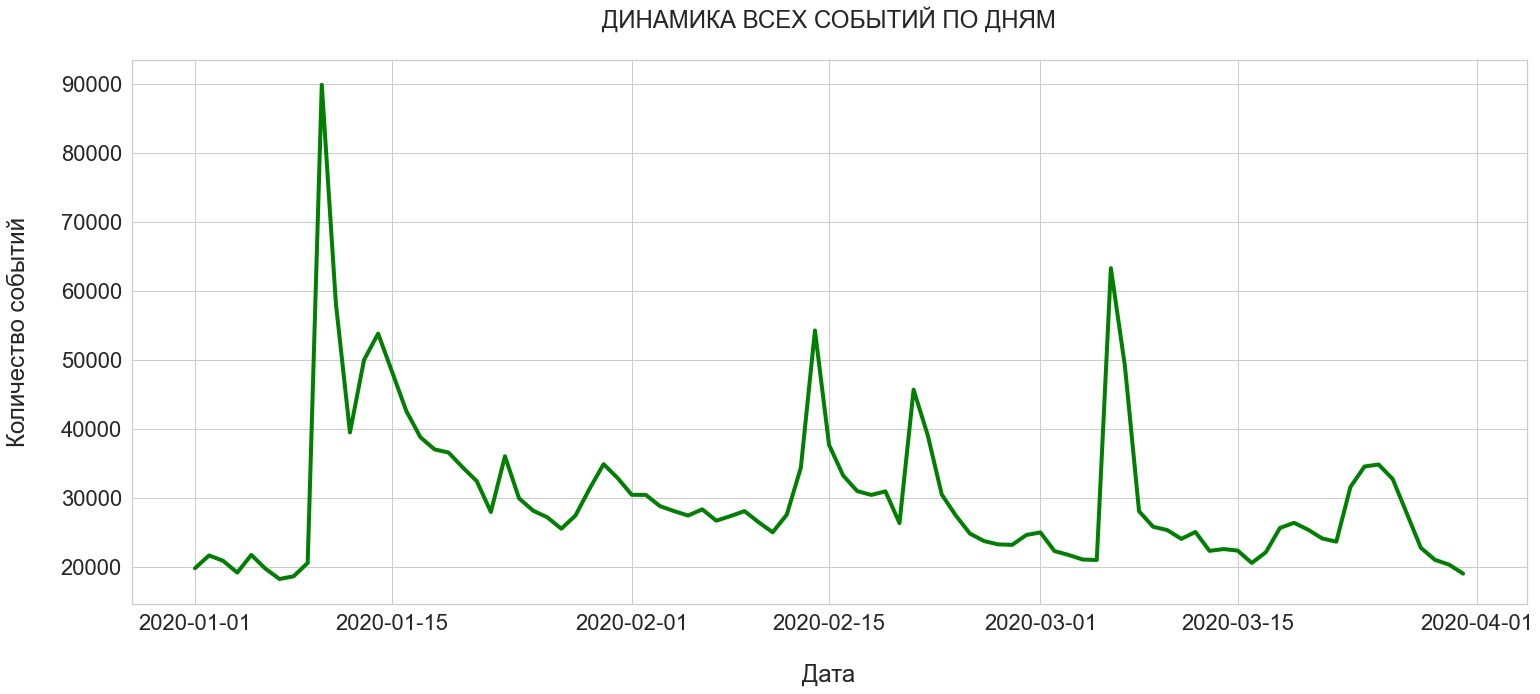

In [6]:
# Посчитаем кол-во всех событий по дням и построим график
data_events = data.groupby('date', as_index = False)\
    .agg({'event' : 'count'})
sns.lineplot(x = data_events['date'], y = data_events['event'], linewidth = 4, color = 'green')
plt.title('ДИНАМИКА ВСЕХ СОБЫТИЙ ПО ДНЯМ\n')
plt.xlabel('\nДата')
plt.ylabel('Количество событий\n')
plt.show()

In [7]:
# Посмотрим в какой день было максимальное количество событий
max_date = data_events[data_events['event'] == data_events['event'].max()]
max_date


,date,event
9,2020-01-10,89831


In [8]:
# Посмотрим в какой день было минимальное количество событий
min_date = data_events[data_events['event'] == data_events['event'].min()]
min_date

,date,event
6,2020-01-07,18226


### Выводы №1:
- Количество событий распределены по дням не равномерно: 
    - наблюдается резкий подъем активности 10 января, 14,21 февраля и 6,7 марта 2020 года; 
    - выше среднего показатели 11, 13, 14 января и 24, 25 марта;
    - спад активности произошел в новогодние праздники, 3-4, 15-17 марта и в конце марта-начале апреля;
    - самая высокая активность была 10 января, а самая низкая 7 января 2020.


- Необходимо  подумать, как увеличить привлечение пользователей в выходные и праздничные дни и выяснить причину спада активности.

### 2. Анализ распределения трафика и динамики открытий приложения группами пользователей, установивших приложение в день первого открытия,  и  остальными пользователями.

In [9]:
# Выделим в отдельный датафрейм только данные с установками приложения ((app_install) для того, чтобы потом выделить 
                                                                            #даты установок)
installs = data[data['event'] == 'app_install'].reset_index()
installs.head()

,index,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2515061,2020-01-01,app_install,0.0,ios,4921563,male,Moscow,vk_ads
1,2515062,2020-01-01,app_install,0.0,ios,1311583,male,Moscow,-
2,2515063,2020-01-01,app_install,0.0,android,23006325,male,Saint-Petersburg,-
3,2515064,2020-01-01,app_install,0.0,android,5645652,male,Moscow,-
4,2515065,2020-01-01,app_install,0.0,ios,8798567,male,Saint-Petersburg,referal


In [10]:
# Создадим функцию, которая будет сравнивать даты
def group_install(date_1, date_2, value_1, value_2):
    if date_1==date_2:
        return value_1
    else:
        return value_2

In [11]:
# Создадим колонку в основном датафрейме (df) с датами установок.
data['date_install'] = data['device_id'].map(installs.set_index('device_id')['date'])

# Добавим столбец, в котором будет информация о принадлежности к определенной группе
data['group_install']  = data.apply(lambda x: group_install(date_1 = x['date'], date_2 = x['date_install'],\
                                        value_1 = 'Установили в тот же день', value_2 = 'Остальные' ), axis = 1)
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,date_install,group_install
0,2020-01-01,app_start,0.0,android,669460,female,Moscow,-,2020-01-01,Установили в тот же день
1,2020-01-01,app_start,0.0,ios,833621,male,Moscow,vk_ads,2020-01-01,Установили в тот же день
2,2020-01-01,app_start,0.0,android,1579237,male,Saint-Petersburg,referal,NaT,Остальные
3,2020-01-01,app_start,0.0,android,1737182,female,Moscow,facebook_ads,2020-01-01,Установили в тот же день
4,2020-01-01,app_start,0.0,ios,4029024,female,Moscow,facebook_ads,2020-01-01,Установили в тот же день


In [12]:
# Посчитаем кол-во открытий приложения по группам
count_app_start = data.query('event == "app_start"')\
                    .groupby('group_install', as_index = False)\
                    .agg({'event' : 'count'})\
                    .rename(columns={'event' : 'count_users'})
count_app_start

,group_install,count_users
0,Остальные,594108
1,Установили в тот же день,154597


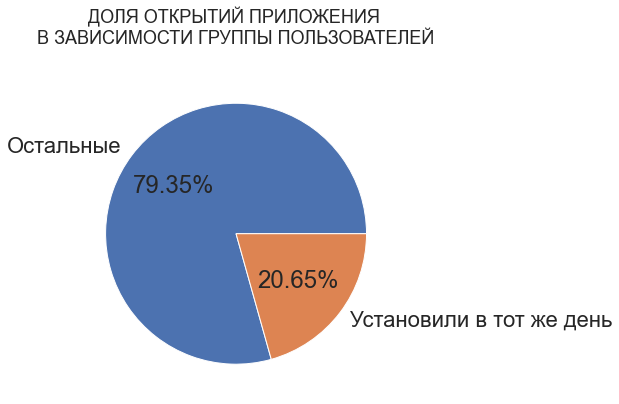

In [13]:
# Визуализируем данные в процентном соотношении
plt.figure(figsize=(6,6))
plt.pie(labels = count_app_start['group_install'], x = count_app_start['count_users'], autopct="%.2f%%")
plt.title('ДОЛЯ ОТКРЫТИЙ ПРИЛОЖЕНИЯ \nВ ЗАВИСИМОСТИ ГРУППЫ ПОЛЬЗОВАТЕЛЕЙ\n', fontsize = 18)
plt.show()

In [14]:
# Сгруппируем данные и посчитаем сколько пользователей открывали приложение по дням
count_app_start_date = data.query('event == "app_start"')\
                    .groupby(['date','group_install'], as_index = False)\
                    .agg({'event' : 'count'})\
                    .rename(columns={'event' : 'count_users'})
count_app_start_date.head()

,date,group_install,count_users
0,2020-01-01,Остальные,866
1,2020-01-01,Установили в тот же день,3579
2,2020-01-02,Остальные,1957
3,2020-01-02,Установили в тот же день,3144
4,2020-01-03,Остальные,2742


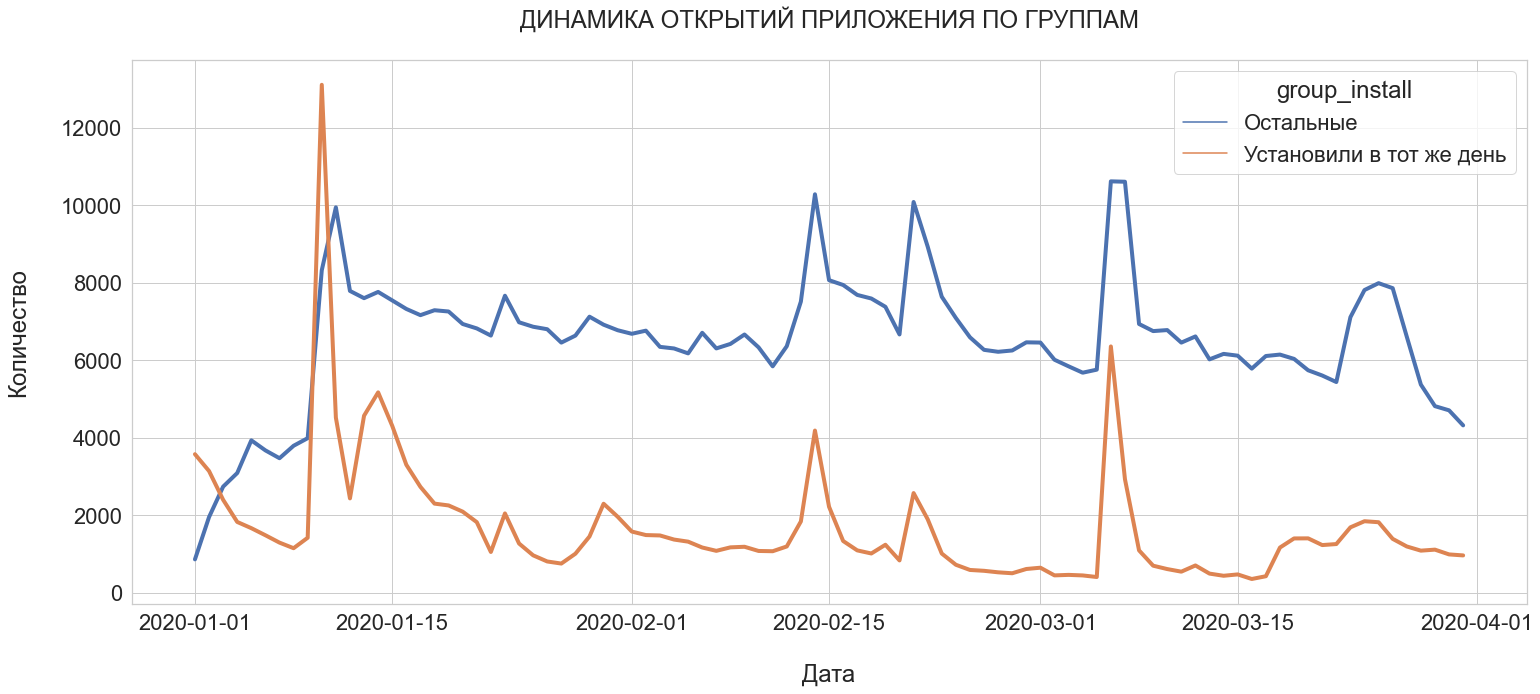

In [15]:
ax = sns.lineplot(x = count_app_start_date['date'], y = count_app_start_date['count_users'], 
                  hue = count_app_start_date['group_install'], linewidth = 4)
ax.set_title('ДИНАМИКА ОТКРЫТИЙ ПРИЛОЖЕНИЯ ПО ГРУППАМ\n')
ax.set_xlabel('\nДата')
ax.set_ylabel('Количество\n')
plt.show()

### Выводы №2:
- 79,35% от всех открытий приложения приходится на пользователей, НЕ устанавливавших приложение в первый день;

- Динамика открытий приложения по дням в двух группах идентичная, за исключением новогодних праздников (т.е. всплески активности и падения ее происходят в одни и те же периоды, за исключением новогодних праздников). 

- Максимальные значения активности в группе "Установили в тот же день" наблюдаются 1-2 и 10-16 января, 6-7 марта и 14 февраля, а минимальные - 2-5 и 14-17 марта, 25-28 февраля.

- Максимальные значения активности в группе "Остальные" наблюдаются 10-11 января, 6-7 и 24-26 марта,  14-16 и 21-22 февраля, а минимальные - 1-9 января и 28-31 марта.

### 3. Анализ трафика от инсталлов

In [16]:
# Создадим сводную таблицу и добавим столбец с трафиком
traffic = count_app_start_date.pivot(index = 'date', columns = 'group_install', values = 'count_users').reset_index()
traffic['Общий трафик'] = traffic['Остальные'] + traffic['Установили в тот же день']
traffic['Доля трафика от инсталлов'] = (traffic['Установили в тот же день'] / traffic['Общий трафик'] * 100).round(2)
traffic['Доля трафика от открытий приложения'] = 100 - traffic['Доля трафика от инсталлов']
traffic = traffic.sort_values('Доля трафика от инсталлов', ascending = False)
traffic.head()

group_install,date,Остальные,Установили в тот же день,Общий трафик,Доля трафика от инсталлов,Доля трафика от открытий приложения
0,2020-01-01,866,3579,4445,80.52,19.48
1,2020-01-02,1957,3144,5101,61.63,38.37
9,2020-01-10,8323,13106,21429,61.16,38.84
2,2020-01-03,2742,2402,5144,46.70,53.30
13,2020-01-14,7764,5173,12937,39.99,60.01


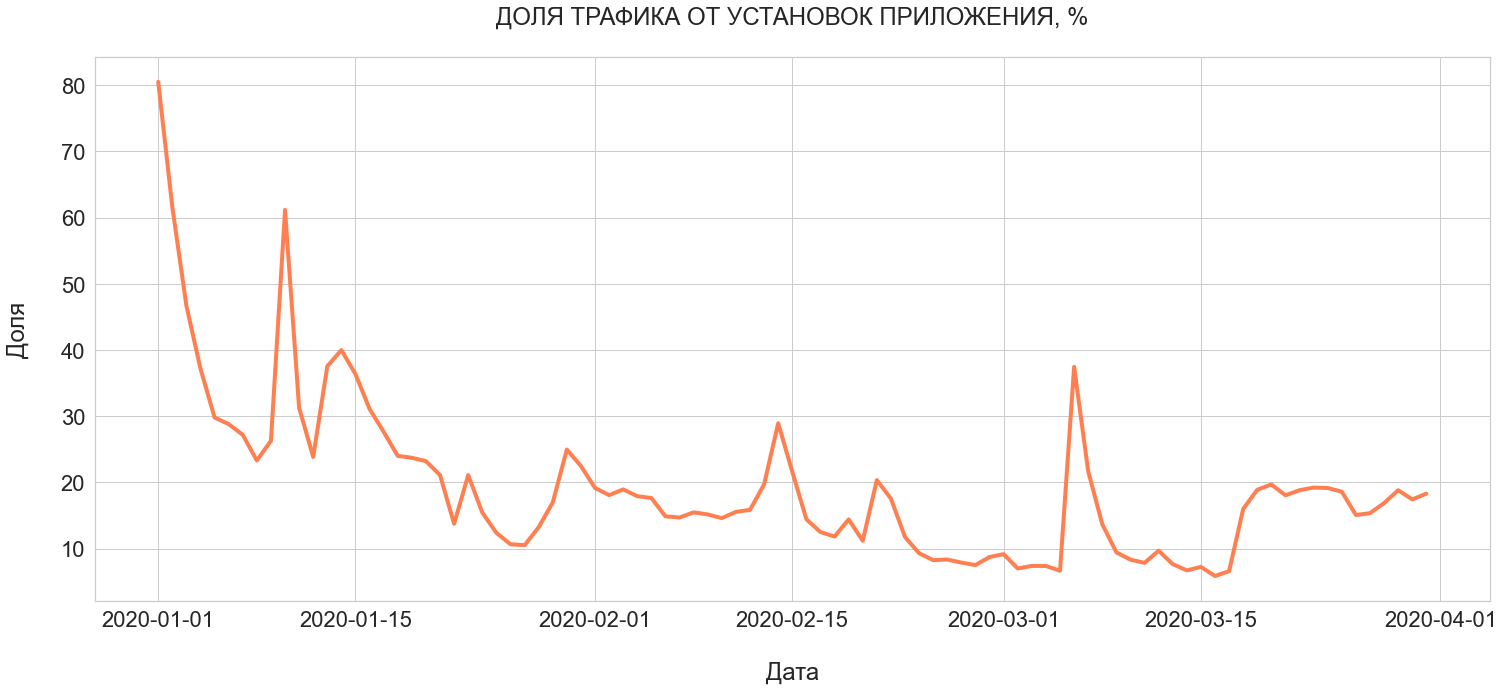

In [17]:
ax = sns.lineplot(x = traffic['date'], y = traffic['Доля трафика от инсталлов'], linewidth = 4, color = 'coral')
ax.set_title('ДОЛЯ ТРАФИКА ОТ УСТАНОВОК ПРИЛОЖЕНИЯ, %\n')
ax.set_xlabel('\nДата')
ax.set_ylabel('Доля\n')
plt.show()

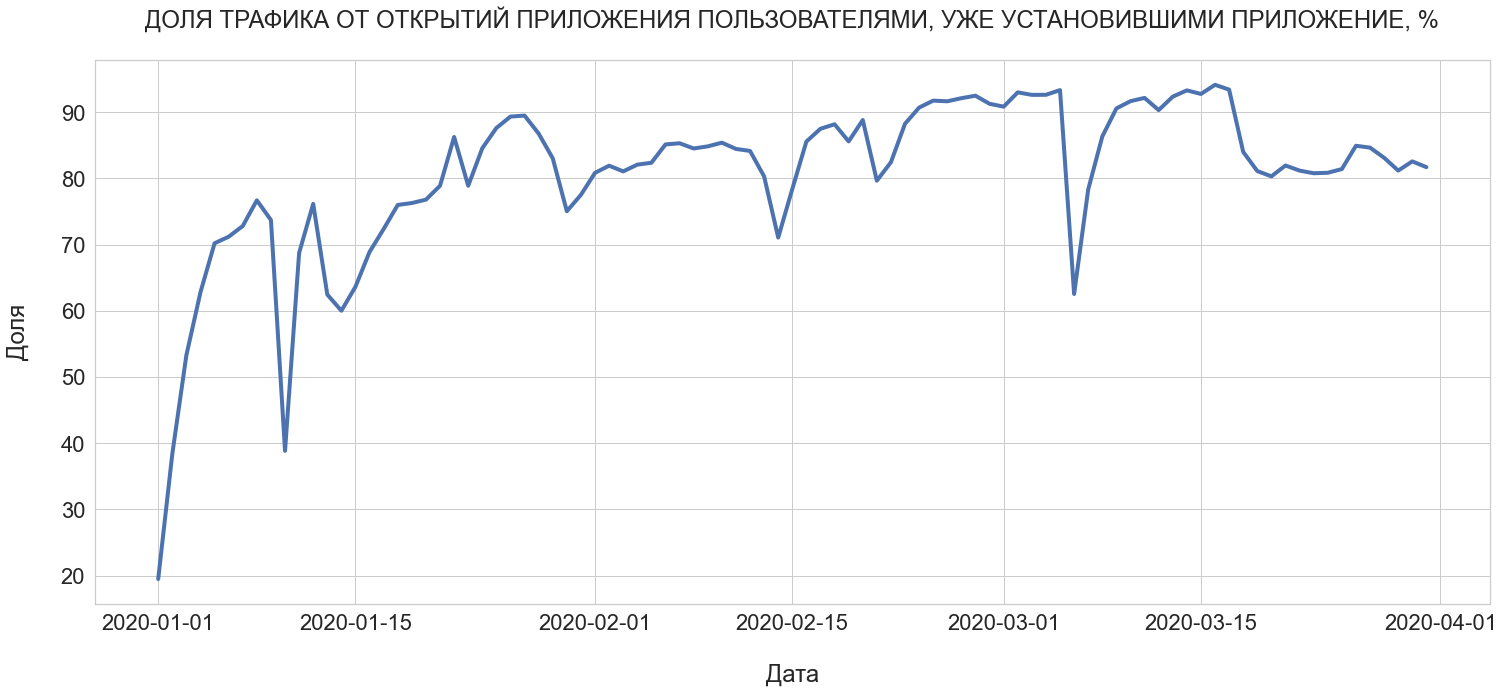

In [18]:
ax = sns.lineplot(x = traffic['date'], y = traffic['Доля трафика от открытий приложения'], linewidth = 4)
ax.set_title('ДОЛЯ ТРАФИКА ОТ ОТКРЫТИЙ ПРИЛОЖЕНИЯ ПОЛЬЗОВАТЕЛЯМИ, УЖЕ УСТАНОВИВШИМИ ПРИЛОЖЕНИЕ, %\n')
ax.set_xlabel('\nДата')
ax.set_ylabel('Доля\n')
plt.show()

### Выводы №3:
- Основная доля трафика приходится на открытие приложения, что очевидно, т.к. установка требуется всего один раз, в отличии от открытия приложения;
- Максимальная доля трафика от инсталлов приходится на 1, 2 и 10 января (80.52%, 61.63% и 61.16%), а в абсолютном выражении максимальное количество инсталов 10 января - 13206 установок, а 1 января всего 3579.
- Минимальная доля трафика от инсталлов приходится на 16 и 17 марта - 5.86% и 6.59% и в абсолютном выражении минимальное количество установок приходится на 16 марта - 360.

### 4. Анализ количества установок и первых открытий приложения по каналам привлечения

In [19]:
# Создадим таблицу с инсталлами с разбивкой по каналам
source_install = data.query('group_install=="Установили в тот же день" and event=="app_install"')\
                    .groupby('utm_source', as_index = False)\
                    .agg({'event' : 'count'})\
                    .rename(columns = {'event' : 'count_install'})\
                    .sort_values('count_install', ascending = False)
# Добавим столбец с процентом установок
source_install['percent_install'] = (source_install['count_install'] * 100 / source_install['count_install']\
                                     .sum())\
                                     .round(1)
source_install

,utm_source,count_install,percent_install
0,-,32460,21.0
6,yandex-direct,29368,19.0
2,google_ads,26286,17.0
5,vk_ads,23189,15.0
3,instagram_ads,20096,13.0
1,facebook_ads,13916,9.0
4,referal,9282,6.0


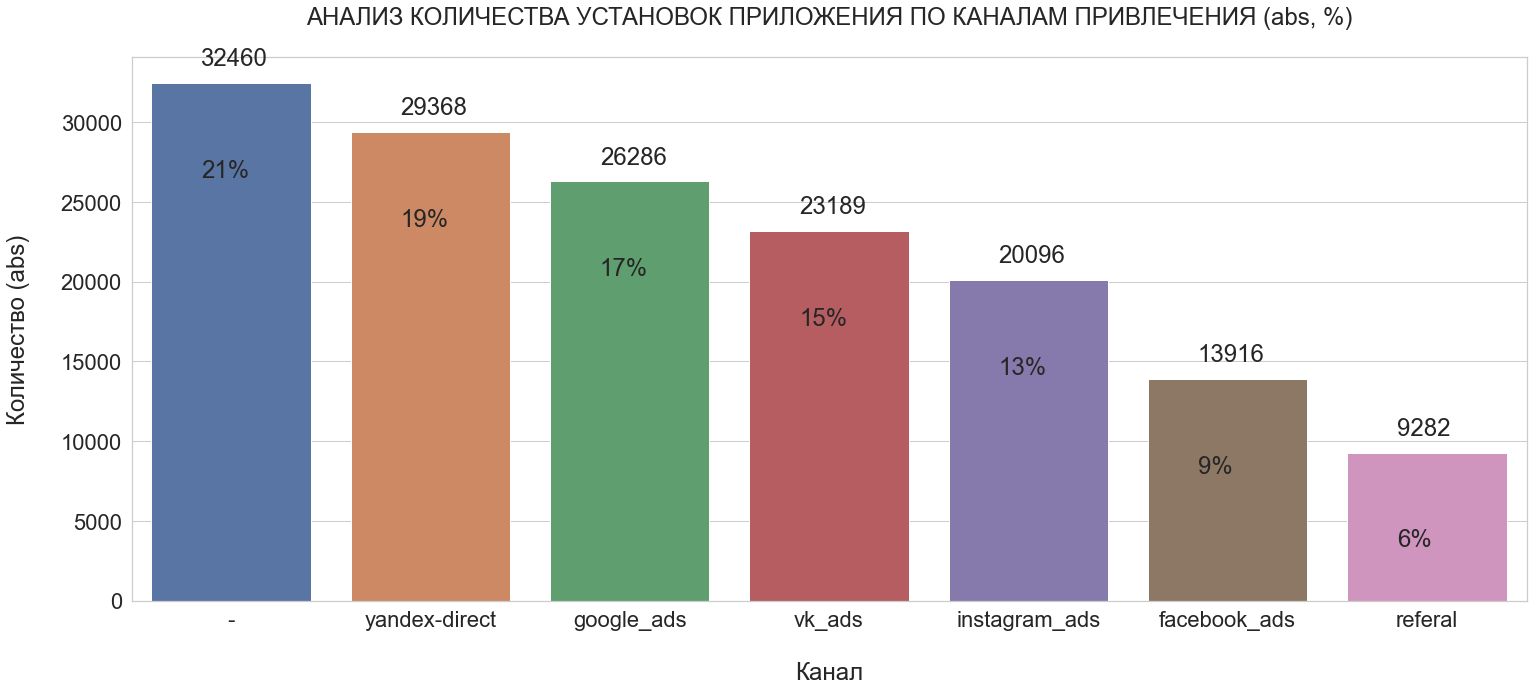

In [20]:
ax = sns.barplot(data = source_install, x = 'utm_source', y = 'count_install')
ax.set_title('АНАЛИЗ КОЛИЧЕСТВА УСТАНОВОК ПРИЛОЖЕНИЯ ПО КАНАЛАМ ПРИВЛЕЧЕНИЯ (abs, %)\n')
ax.set_xlabel('\nКанал')
ax.set_ylabel('Количество (abs)\n')
plt.text(-0.15, 33560, '32460')
plt.text(-0.15, 26560, '21%')
plt.text(0.85, 30468, '29368')
plt.text(0.85, 23468, '19%')
plt.text(1.85, 27386, '26286')
plt.text(1.85, 20386, '17%')
plt.text(2.85, 24289, '23189')
plt.text(2.85, 17289, '15%')
plt.text(3.85, 21196, '20096')
plt.text(3.85, 14196, '13%')
plt.text(4.85, 15016, '13916')
plt.text(4.85, 8016, '9%')
plt.text(5.85, 10382, '9282')
plt.text(5.85, 3382, '6%')
plt.show()

In [21]:
# Создадим таблицу с инсталлами с разбивкой по каналам и датам
source_install_date = data.query('group_install=="Установили в тот же день" and event=="app_install"')\
                    .groupby(['date', 'utm_source'], as_index = False)\
                    .agg({'event' : 'count'})\
                    .rename(columns = {'event' : 'count_install'})\
                    .sort_values('count_install', ascending = False)\
                    .reset_index()\
                    .drop('index', axis = 1)
source_install_date.head()

,date,utm_source,count_install
0,2020-01-10,-,2704
1,2020-01-10,yandex-direct,2493
2,2020-01-10,google_ads,2256
3,2020-01-10,vk_ads,1972
4,2020-01-10,instagram_ads,1686


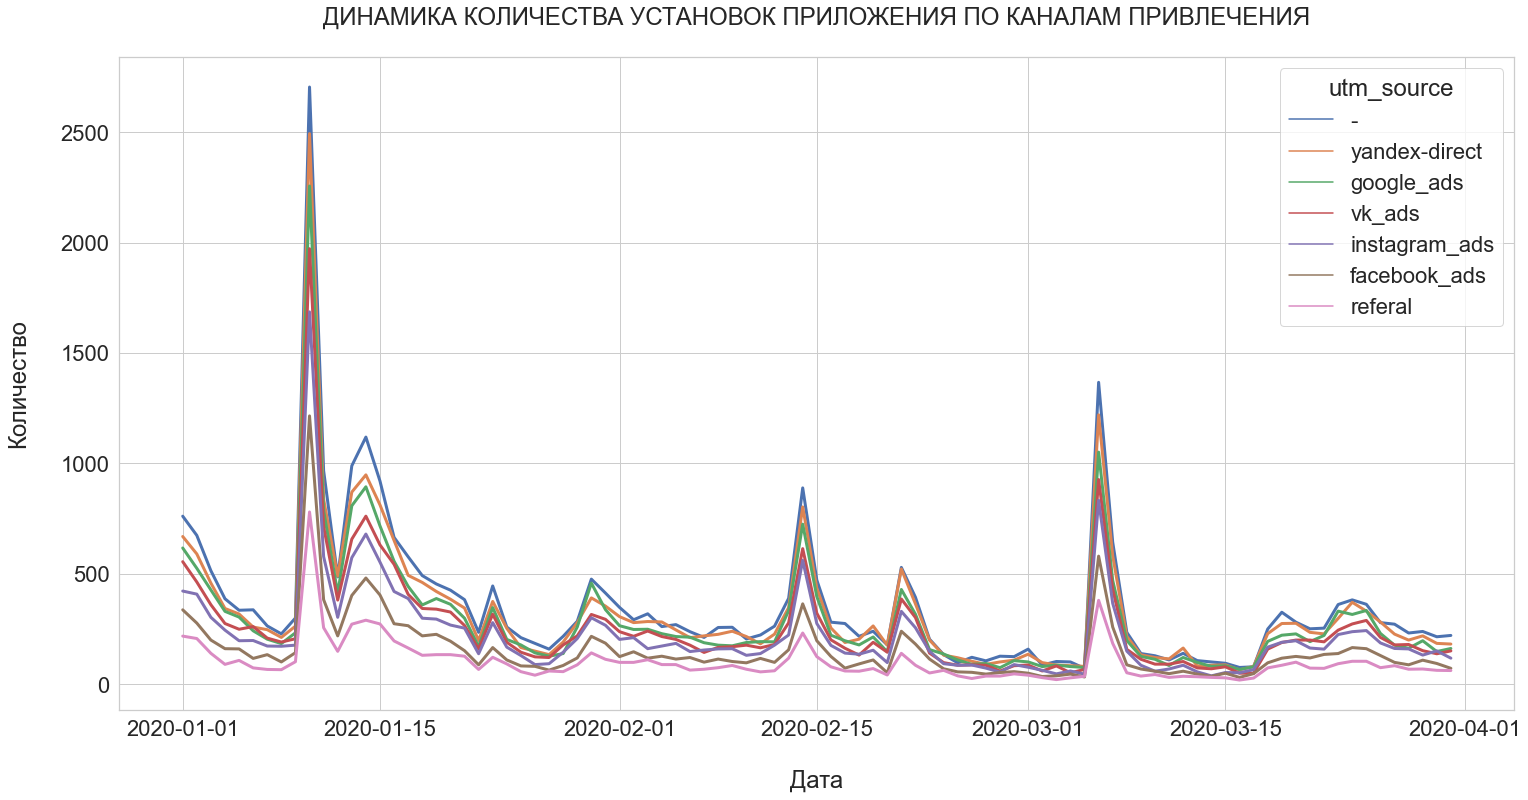

In [22]:
plt.figure(figsize = (25, 12))
ax = sns.lineplot(data = source_install_date, x = 'date', y = 'count_install', hue = 'utm_source', linewidth = 3)
ax.set_title('ДИНАМИКА КОЛИЧЕСТВА УСТАНОВОК ПРИЛОЖЕНИЯ ПО КАНАЛАМ ПРИВЛЕЧЕНИЯ\n')
ax.set_xlabel('\nДата')
ax.set_ylabel('Количество\n')
plt.show()

In [23]:
# Создадим таблицу с первыми открытиями приложения с разбивкой по каналам
first_start_source = data.query('event=="app_start"')\
                         .drop_duplicates('device_id')\
                         .groupby(['utm_source'], as_index = False)\
                         .agg({'device_id' : 'count'})\
                         .sort_values('device_id', ascending = False)\
                         .rename(columns = {'device_id' : 'count_start'})
# Добавим столбец с процентом первых открытий приложения
first_start_source['percent_start'] = (first_start_source['count_start'] * 100 / first_start_source['count_start']\
                                       .sum())\
                                       .round(1)                      
first_start_source.head()

,utm_source,count_start,percent_start
0,-,41456,21.7
6,yandex-direct,34441,18.0
2,google_ads,31437,16.5
5,vk_ads,27905,14.6
3,instagram_ads,24818,13.0


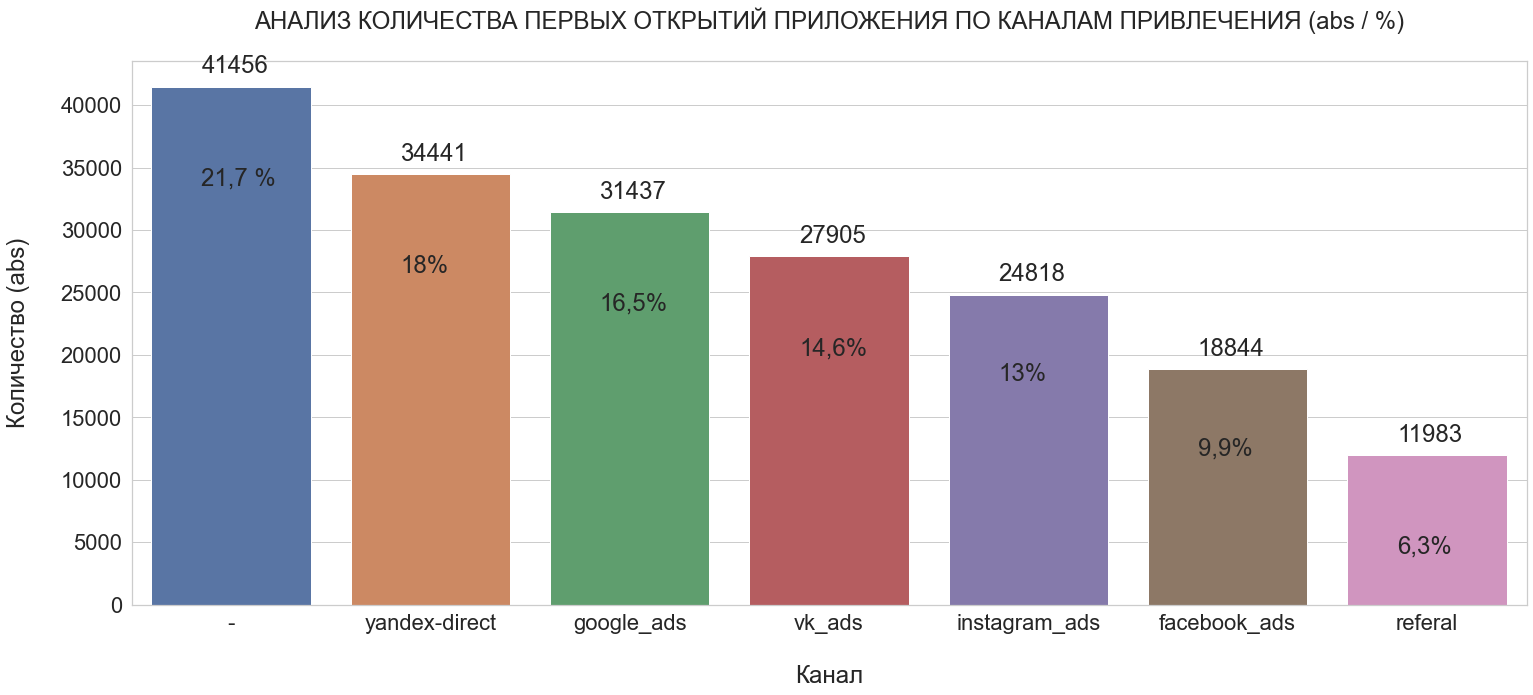

In [24]:
ax = sns.barplot(data = first_start_source, x = 'utm_source', y = 'count_start')
ax.set_title('АНАЛИЗ КОЛИЧЕСТВА ПЕРВЫХ ОТКРЫТИЙ ПРИЛОЖЕНИЯ ПО КАНАЛАМ ПРИВЛЕЧЕНИЯ (abs / %)\n')
ax.set_xlabel('\nКанал')
ax.set_ylabel('Количество (abs)\n')
plt.text(-0.15, 42556,'41456')
plt.text(-0.15, 33556,'21,7 %')
plt.text(0.85, 35541, '34441')
plt.text(0.85, 26541, '18%')
plt.text(1.85, 32537, '31437')
plt.text(1.85, 23537, '16,5%')
plt.text(2.85, 29005, '27905')
plt.text(2.85, 20005, '14,6%')
plt.text(3.85, 25918, '24818')
plt.text(3.85, 17918, '13%')
plt.text(4.85, 19944, '18844')
plt.text(4.85, 11944, '9,9%')
plt.text(5.85, 13083, '11983')
plt.text(5.85, 4083, '6,3%')
plt.show()

In [25]:
# Создадим таблицу с первыми открытиями приложения с разбивкой по каналам и датам
start_source_date = data.query('event=="app_start"')\
                         .drop_duplicates('device_id')\
                         .groupby(['date','utm_source'], as_index = False)\
                         .agg({'device_id' : 'count'})\
                         .sort_values('device_id', ascending = False)\
                         .rename(columns = {'device_id' : 'count_start'})\
                         .reset_index()\
                         .drop('index', axis = 1)
start_source_date.head()

,date,utm_source,count_start
0,2020-01-10,-,3504
1,2020-01-10,yandex-direct,2919
2,2020-01-10,google_ads,2694
3,2020-01-10,vk_ads,2403
4,2020-01-10,instagram_ads,2078


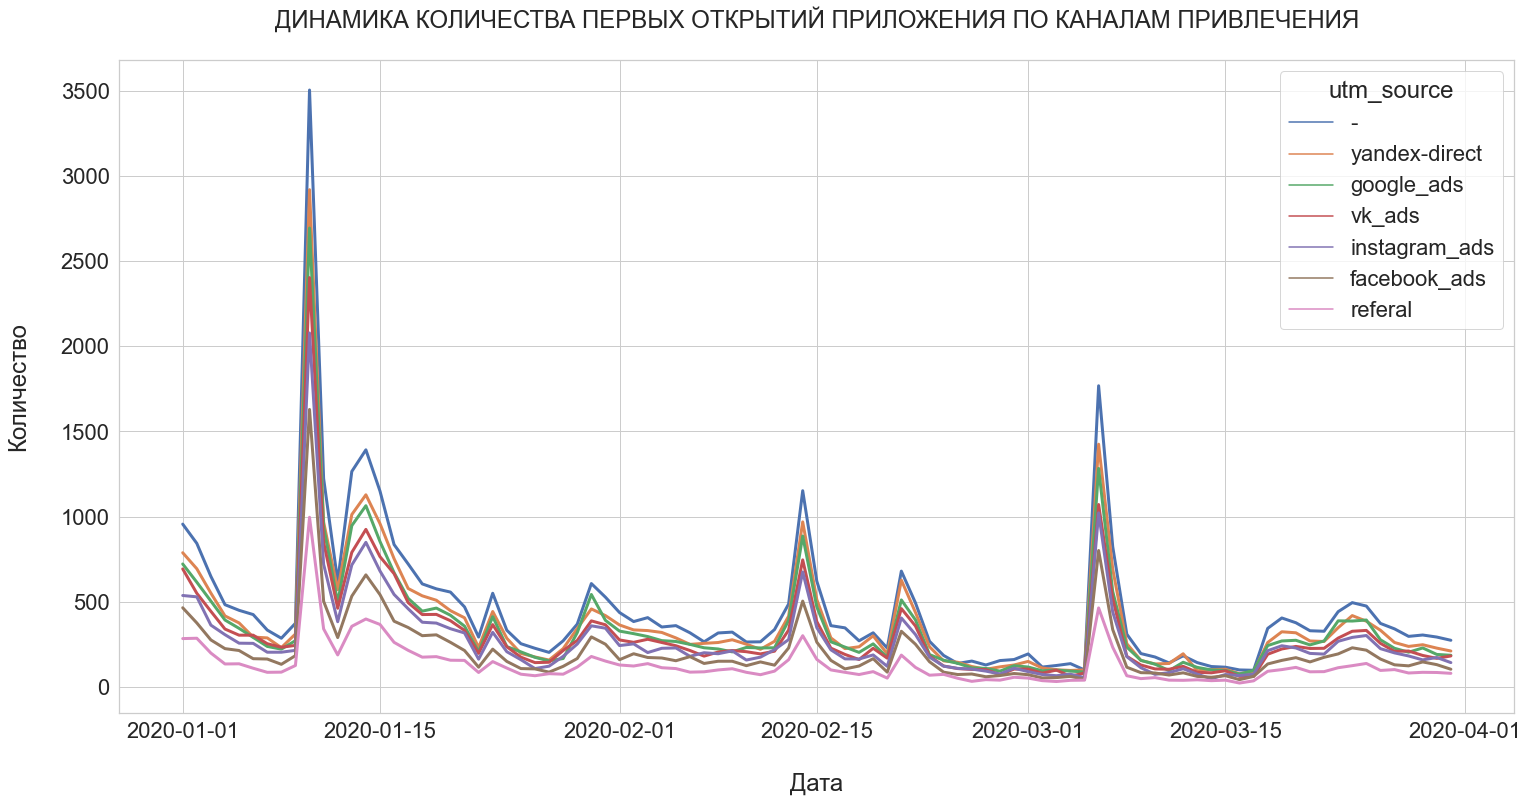

In [26]:
plt.figure(figsize = (25, 12))
ax = sns.lineplot(data = start_source_date, x = 'date', y = 'count_start', hue = 'utm_source', linewidth = 3)
ax.set_title('ДИНАМИКА КОЛИЧЕСТВА ПЕРВЫХ ОТКРЫТИЙ ПРИЛОЖЕНИЯ ПО КАНАЛАМ ПРИВЛЕЧЕНИЯ\n')
ax.set_xlabel('\nДата')
ax.set_ylabel('Количество\n')
plt.show()

### Выводы 4
- Самыми эффективными каналами по привлечению пользователей являются Яндекс, Гугл и ВК:
    - Янедкс - 18% новых пользователей
    - Гугл - 16.5%
    - ВК - 14.6%
    

- Самыми эффективными каналами по установкам приложения тоже являются Яндекс, Гугл и ВК:
    - Янедкс - 19% 
    - Гугл - 17%
    - ВК - 15%
    

- Меньше всего пользователей и установок от Реферальной программы и Фейсбука.


- Динамика первых открытий и установок приложения по дням идентичная по всем каналам (т.е. всплески и падения происходят в одни и те же периоды). 

### 5. Анализ воронки для зарегистрированных и незарегистрированных пользователей по каналам привлечения

In [27]:
# Выделим в отдельный датафрейм данные c регистрациями
df_reg = data[data['event'] =="register"]\
                    .sort_values('date')\
                    .drop_duplicates('device_id')\
                    .reset_index()
df_reg.head()

,index,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,date_install,group_install
0,2669658,2020-01-01,register,0.0,ios,294193,female,Saint-Petersburg,instagram_ads,NaT,Остальные
1,2670356,2020-01-01,register,0.0,ios,21780,female,Saint-Petersburg,yandex-direct,2020-01-01,Установили в тот же день
2,2670357,2020-01-01,register,0.0,ios,2470180,male,Moscow,google_ads,2020-01-01,Установили в тот же день
3,2670358,2020-01-01,register,0.0,android,3735668,male,Moscow,instagram_ads,2020-01-01,Установили в тот же день
4,2670359,2020-01-01,register,0.0,android,11372938,male,Saint-Petersburg,-,2020-01-01,Установили в тот же день


In [28]:
# Добавим в основной датафрейм колонку с датой регистрации
data['date_reg'] = data['device_id'].map(df_reg.set_index('device_id')['date'])

In [29]:
# Выделим пользователей,которые зарегистрировались (date_reg НЕ NaN), чтобы использовать эту информацию при сегментировании
df_registered = data[data['date_reg'].isna()==False].reset_index()

# Выделим пользователей,которые не зарегистрировались за весь период (date_reg - NaN), чтобы использовать эту информацию при сегментировании
df_not_registered = data[data['date_reg'].isna()== True].reset_index()

In [30]:
# Напишем функцию, которая будет сравнивать даты
def group_register(date_1, date_2, value_1, value_2):
    if date_1 <= date_2:
        return value_1
    else:
        return value_2

In [31]:
# Добавим столбец в df_registered с деление на группы по регистрации
df_registered['reg_group'] = df_registered.apply(lambda x: group_register(date_1 = x['date'], date_2 = x['date_reg'],\
                                                            value_1 = "not_registered", value_2 = "registered"), axis = 1)

In [32]:
# Добавим столбец и значение "not_registerd" в df_not_registered
df_not_registered['reg_group'] = 'not_registered'

In [33]:
# Объединим датафреймы
data = pd.concat([df_registered, df_not_registered])
data.head()

,index,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,date_install,group_install,date_reg,reg_group
0,0,2020-01-01,app_start,0.0,android,669460,female,Moscow,-,2020-01-01,Установили в тот же день,2020-01-07,not_registered
1,1,2020-01-01,app_start,0.0,ios,833621,male,Moscow,vk_ads,2020-01-01,Установили в тот же день,2020-01-01,not_registered
2,2,2020-01-01,app_start,0.0,android,1579237,male,Saint-Petersburg,referal,NaT,Остальные,2020-01-01,not_registered
3,3,2020-01-01,app_start,0.0,android,1737182,female,Moscow,facebook_ads,2020-01-01,Установили в тот же день,2020-01-01,not_registered
4,5,2020-01-01,app_start,0.0,android,5148476,male,Saint-Petersburg,-,2020-01-01,Установили в тот же день,2020-01-24,not_registered


In [34]:
# Cгруппируем данные о зарегистрированных пользователях и посчитаем кол-во событий по каналам привлечения
funnel_group_reg = data.query('reg_group=="registered"')\
                        .groupby(['utm_source', 'event'], as_index = False)\
                        .agg({'device_id' : pd.Series.nunique})\
                        .rename(columns = {'device_id' : 'count_users' })\
                        .pivot(index = 'utm_source', columns = 'event', values = 'count_users' )
funnel_group_reg

event,app_start,choose_item,purchase,search,tap_basket
utm_source,,,,,
-,9482,8728,5492,9355,7850
facebook_ads,5606,5154,3333,5527,4694
google_ads,5399,4948,3121,5335,4438
instagram_ads,5686,5288,3548,5618,4842
referal,3647,3417,2382,3610,3155
vk_ads,6011,5636,3950,5958,5196
yandex-direct,5396,4928,3099,5304,4464


In [35]:
# # Добавим колонки с конверсией для каждого шага

# Конверсия: Открытие приложения - Поиск
funnel_group_reg['START /search'] = round(funnel_group_reg['search'] * 100 / funnel_group_reg['app_start'],2) 

# Конверсия: Поиск - Добавление товара в корзину
funnel_group_reg['SEARCH /choose_item'] = round(funnel_group_reg['choose_item'] * 100 / funnel_group_reg['search'],2)

# Конверсия: Добавление в корзину - переход в корзину
funnel_group_reg['CHOOSE_ITEM /tap_basket'] = round(funnel_group_reg['tap_basket'] *100 / funnel_group_reg['choose_item'],2) 
 
# Конверсия: Переход в корзину - Покупка
funnel_group_reg['TAP_BASKET /purchase'] = round(funnel_group_reg['purchase'] * 100 / funnel_group_reg['tap_basket'],2) 

funnel_group_reg.head()

event,app_start,choose_item,purchase,search,tap_basket,START /search,SEARCH /choose_item,CHOOSE_ITEM /tap_basket,TAP_BASKET /purchase
utm_source,,,,,,,,,
-,9482,8728,5492,9355,7850,98.66,93.30,89.94,69.96
facebook_ads,5606,5154,3333,5527,4694,98.59,93.25,91.07,71.01
google_ads,5399,4948,3121,5335,4438,98.81,92.75,89.69,70.32
instagram_ads,5686,5288,3548,5618,4842,98.80,94.13,91.57,73.28
referal,3647,3417,2382,3610,3155,98.99,94.65,92.33,75.50


In [36]:
# Возьмем только нужные столбцы
funnel_group_reg_new = funnel_group_reg[['START /search', 'SEARCH /choose_item', 'CHOOSE_ITEM /tap_basket',
                                        'TAP_BASKET /purchase']]
# Транспонируем датафрейм и сделаем визуализацию
funnel_group_reg_new = funnel_group_reg_new.T
funnel_group_reg_new

utm_source,-,facebook_ads,google_ads,instagram_ads,referal,vk_ads,yandex-direct
event,,,,,,,
START /search,98.66,98.59,98.81,98.80,98.99,99.12,98.30
SEARCH /choose_item,93.30,93.25,92.75,94.13,94.65,94.60,92.91
CHOOSE_ITEM /tap_basket,89.94,91.07,89.69,91.57,92.33,92.19,90.58
TAP_BASKET /purchase,69.96,71.01,70.32,73.28,75.50,76.02,69.42


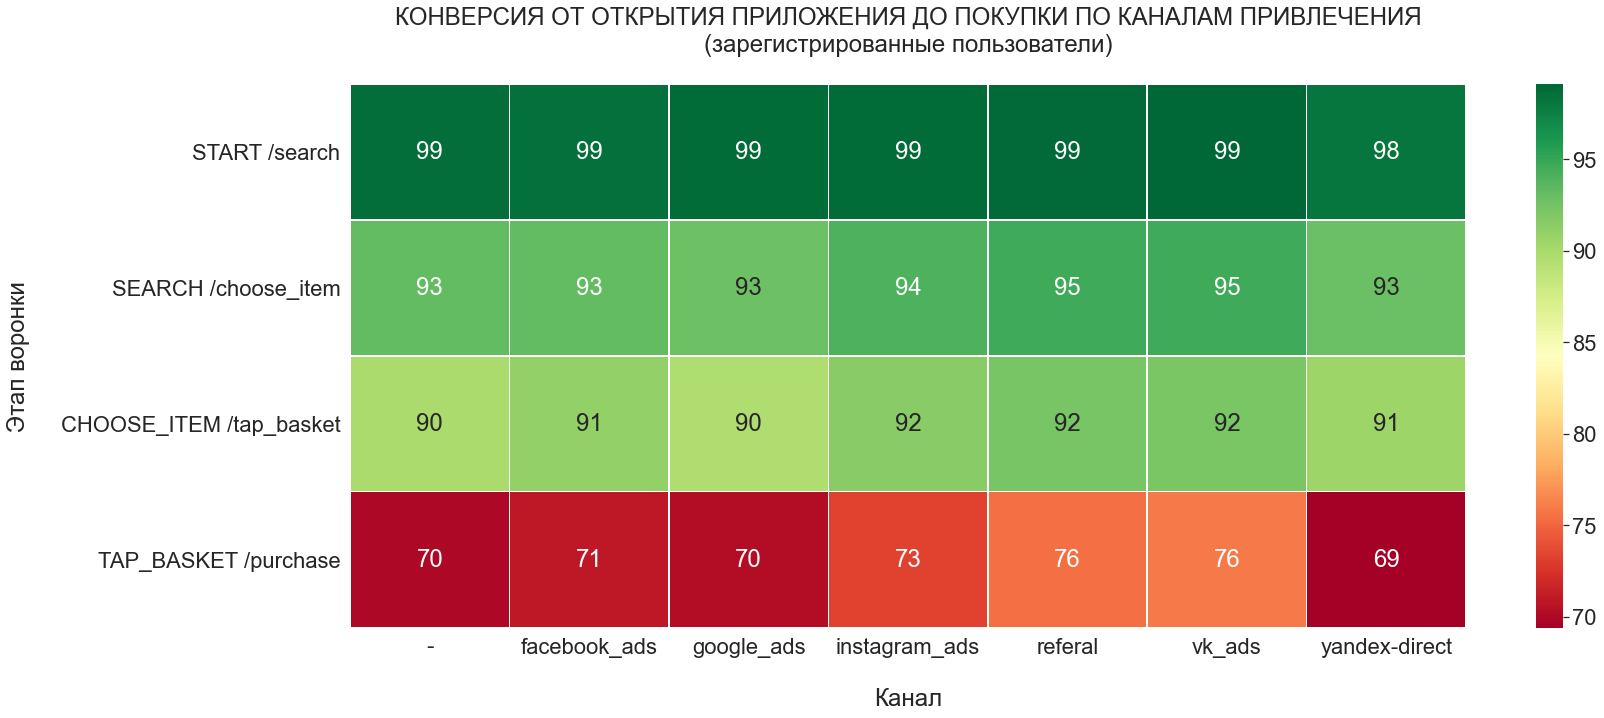

In [37]:
ax = sns.heatmap(funnel_group_reg_new, annot=True, fmt=".0f",  cmap="RdYlGn", linewidths=.5)
ax.set_title("КОНВЕРСИЯ ОТ ОТКРЫТИЯ ПРИЛОЖЕНИЯ ДО ПОКУПКИ ПО КАНАЛАМ ПРИВЛЕЧЕНИЯ\n(зарегистрированные пользователи)\n")
ax.set_xlabel('\nКанал')
ax.set_ylabel('Этап воронки\n')
plt.show()   

In [38]:
# Cгруппируем данные о незарегистрированных пользователях и посчитаем кол-во событий по каналам привлечения
funnel_group_not_reg = data.query('reg_group=="not_registered"')\
                            .groupby(['utm_source', 'event'], as_index = False)\
                            .agg({'device_id' : pd.Series.nunique})\
                            .rename(columns = {'device_id' : 'count_users' })\
                            .pivot(index = 'utm_source', columns = 'event', values = 'count_users' )#.reset_index()
funnel_group_not_reg

event,app_install,app_start,choose_item,purchase,register,search,tap_basket
utm_source,,,,,,,
-,32460,48670,38026,14073,16527,46742,29223
facebook_ads,13916,23780,18713,7506,8672,22822,14592
google_ads,26286,35778,27416,9777,11405,34217,20765
instagram_ads,20096,29237,22858,9394,10750,28017,17881
referal,9282,14866,11880,5503,6193,14316,9518
vk_ads,23189,32353,25422,10919,12421,31010,20014
yandex-direct,29368,38578,29591,10581,12342,36933,22417


In [39]:
# # Добавим колонки с конверсией для каждого шага

# Конверсия: Открытие приложения - Поиск
funnel_group_not_reg['START /search'] = round(funnel_group_not_reg['search'] * 100 / funnel_group_not_reg['app_start'],2) 

# Конверсия: Поиск - Добавление товара в корзину
funnel_group_not_reg['SEARCH /choose_item'] = round(funnel_group_not_reg['choose_item']*100/funnel_group_not_reg['search'],2)

# Конверсия: Добавление в корзину - переход в корзину
funnel_group_not_reg['CHOOSE_ITEM /tap_basket']=round(funnel_group_not_reg['tap_basket']*100/funnel_group_not_reg['choose_item'],2) 
 
# Конверсия: Переход в корзину - Pегистрация
funnel_group_not_reg['TAP_BASKET /register']=round(funnel_group_not_reg['register']*100/funnel_group_not_reg['tap_basket'],2) 

# Конверсия: Pегистрация - Покупка
funnel_group_not_reg['REGISTER /purchase'] = round(funnel_group_not_reg['purchase']*100 / funnel_group_not_reg['register'],2)

funnel_group_not_reg.head()

event,app_install,app_start,choose_item,purchase,register,search,tap_basket,START /search,SEARCH /choose_item,CHOOSE_ITEM /tap_basket,TAP_BASKET /register,REGISTER /purchase
utm_source,,,,,,,,,,,,
-,32460,48670,38026,14073,16527,46742,29223,96.04,81.35,76.85,56.55,85.15
facebook_ads,13916,23780,18713,7506,8672,22822,14592,95.97,82.00,77.98,59.43,86.55
google_ads,26286,35778,27416,9777,11405,34217,20765,95.64,80.12,75.74,54.92,85.73
instagram_ads,20096,29237,22858,9394,10750,28017,17881,95.83,81.59,78.23,60.12,87.39
referal,9282,14866,11880,5503,6193,14316,9518,96.30,82.98,80.12,65.07,88.86


In [40]:
# Возьмем только нужные столбцы
funnel_group_not_reg_new = funnel_group_not_reg[['START /search', 'SEARCH /choose_item', 'CHOOSE_ITEM /tap_basket',
                            'TAP_BASKET /register', 'REGISTER /purchase']]

# Транспонируем датафрейм и сделаем визуализацию
funnel_group_not_reg_new = funnel_group_not_reg_new.T
funnel_group_not_reg_new

utm_source,-,facebook_ads,google_ads,instagram_ads,referal,vk_ads,yandex-direct
event,,,,,,,
START /search,96.04,95.97,95.64,95.83,96.30,95.85,95.74
SEARCH /choose_item,81.35,82.00,80.12,81.59,82.98,81.98,80.12
CHOOSE_ITEM /tap_basket,76.85,77.98,75.74,78.23,80.12,78.73,75.76
TAP_BASKET /register,56.55,59.43,54.92,60.12,65.07,62.06,55.06
REGISTER /purchase,85.15,86.55,85.73,87.39,88.86,87.91,85.73


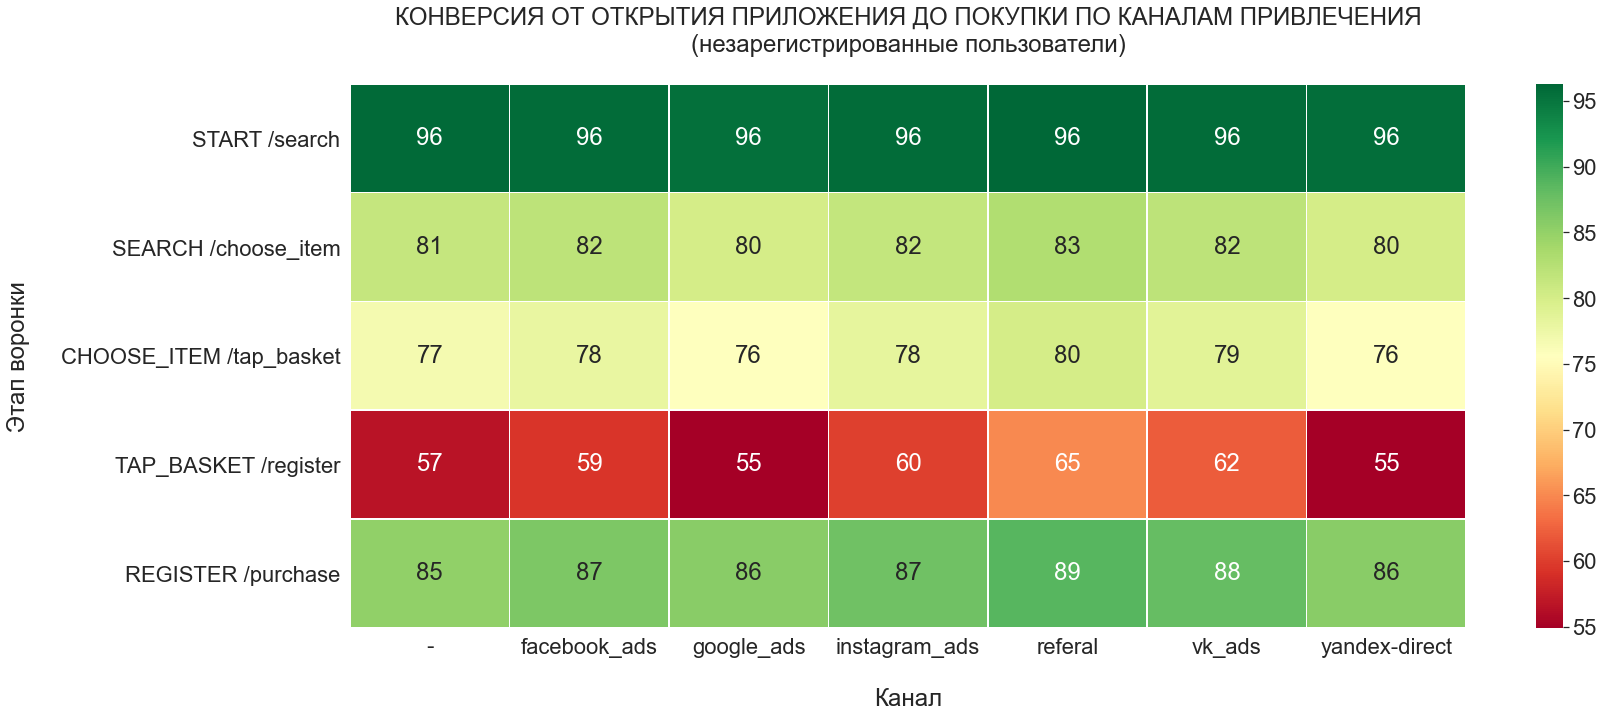

In [41]:
ax = sns.heatmap(funnel_group_not_reg_new, annot=True, fmt=".0f",  cmap="RdYlGn", linewidths=.5)
ax.set_title("КОНВЕРСИЯ ОТ ОТКРЫТИЯ ПРИЛОЖЕНИЯ ДО ПОКУПКИ ПО КАНАЛАМ ПРИВЛЕЧЕНИЯ\n(незарегистрированные пользователи)\n")
ax.set_xlabel('\nКанал')
ax.set_ylabel('Этап воронки\n')
plt.show()   

### Выводы №5:
- В группе зарегистрированных пользователей большая часть клиентов "отваливается" на этапе покупки (конверсия в покупку составляет 69-76%). Однако, стоит заметить, что показатели конверсии в покупку достатьчно высоки. Лидерами конверсии на этом этапе являются:
    - Реферальная программа - 76%
    - ВК - 76%
    - Инстаграмм - 73%


- В группе незарегистрированных пользователей большая часть клиентов "отваливается" на этапе регистрации (конверсия в регистрацию составляет 55-65%). Возможно, стоит задуматься об упрощении процедуры регистрации. Лидерами конверсии на этом этапе являются:
    - Реферальная программа - 65%
    - ВК - 62%
    - Инстаграмм - 60%
    
    
- У незарегистрированных пользователей процент конверсии в покупку выше, чем у зарегистрированных, однако на всех остальных этапах конверсия выше у зарегистрированных пользователей.

### 6. Анализ конверсии в первую покупку по каналам привлечения

In [42]:
# Посчитаем кол-во первых открытий приложения по каналам привлечения
first_app_start = data.query('event=="app_start"')\
                        .sort_values('date')\
                        .drop_duplicates('device_id')\
                        .groupby('utm_source', as_index = False)\
                        .agg({'date' : 'count'})\
                        .rename(columns = {'date' : 'count_start'})
first_app_start

,utm_source,count_start
0,-,41456
1,facebook_ads,18844
2,google_ads,31437
3,instagram_ads,24818
4,referal,11983
5,vk_ads,27905
6,yandex-direct,34441


In [43]:
# Посчитаем кол-во первых покупок по каналам привлечения 
first_purchase_group = data.query('event=="purchase"')\
                        .sort_values('date')\
                        .drop_duplicates('device_id')\
                        .groupby('utm_source', as_index = False)\
                        .agg({'date' : 'count'})\
                        .rename(columns = {'date' : 'count_purchase'})

first_purchase_group

,utm_source,count_purchase
0,-,14786
1,facebook_ads,7903
2,google_ads,10167
3,instagram_ads,9820
4,referal,5803
5,vk_ads,11460
6,yandex-direct,10936


In [44]:
# Посчитаем конверсию в первую покупку
conversion_rate = first_app_start.merge(first_purchase_group, how = 'left', on = 'utm_source')
conversion_rate['CR_first_purch'] = (conversion_rate['count_purchase'] * 100 / conversion_rate['count_start']).round(2) 
conversion_rate = conversion_rate.sort_values('CR_first_purch', ascending = False)
conversion_rate

,utm_source,count_start,count_purchase,CR_first_purch
4,referal,11983,5803,48.43
1,facebook_ads,18844,7903,41.94
5,vk_ads,27905,11460,41.07
3,instagram_ads,24818,9820,39.57
0,-,41456,14786,35.67
2,google_ads,31437,10167,32.34
6,yandex-direct,34441,10936,31.75


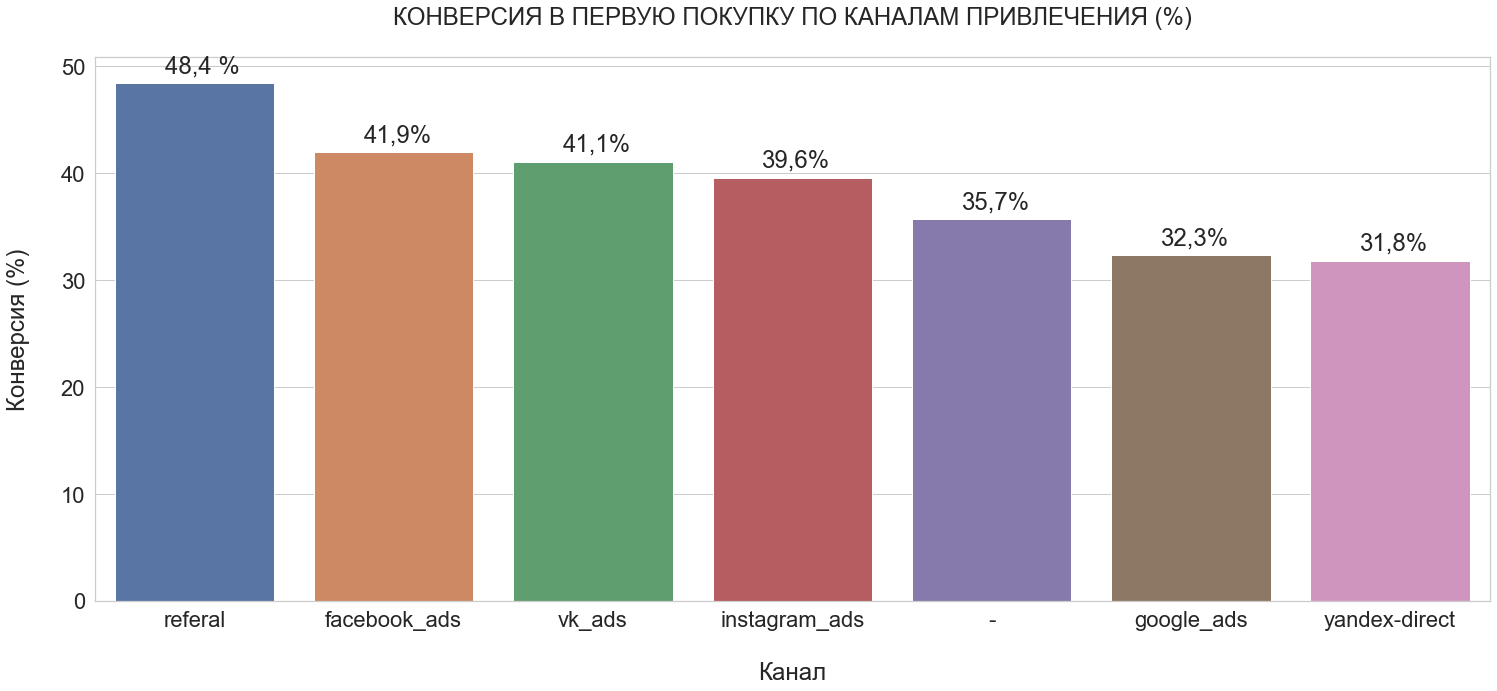

In [45]:
ax = sns.barplot(data = conversion_rate, x = 'utm_source', y = 'CR_first_purch')
ax.set_title('КОНВЕРСИЯ В ПЕРВУЮ ПОКУПКУ ПО КАНАЛАМ ПРИВЛЕЧЕНИЯ (%)\n')
ax.set_xlabel('\nКанал')
ax.set_ylabel('Конверсия (%)\n')
plt.text(-0.15, 49.4,'48,4 %')
plt.text(0.85, 42.9, '41,9%')
plt.text(1.85, 42.1, '41,1%')
plt.text(2.85, 40.6, '39,6%')
plt.text(3.85, 36.7, '35,7%')
plt.text(4.85, 33.3, '32,3%')
plt.text(5.85, 32.8, '31,8%')
plt.show()

### Выводы №6:
Самыми эффективными каналами привлечения по конверсии в покупку являются:
- Реферальная программа - 48.4%
- Фейсбук - 41.9%
- ВК - 41.1%

Самыми неэффективными каналами привлечения по конверсии в покупку являются:
- Яндекс - 31.8%
- Гугл - 32.3%


### 7. Анализ среднего и медианного первого чека по каналам привлечения

In [46]:
# Посчитаем медианный первый чек по каналам привлечения
first_purchase_median = data.query('event=="purchase"')\
                            .sort_values('date')\
                            .drop_duplicates('device_id')\
                            .groupby('utm_source')\
                            .agg({'purchase_sum' : 'median'})\
                            .rename(columns = {'purchase_sum' : 'median_first_purch'})
first_purchase_median

,median_first_purch
utm_source,
-,398.5
facebook_ads,389.0
google_ads,390.5
instagram_ads,393.5
referal,395.5
vk_ads,393.0
yandex-direct,392.5


In [47]:
# Посчитаем средний первый чек по каналам привлечения 
first_purchase_mean = data.query('event=="purchase"')\
                            .sort_values('date')\
                            .drop_duplicates('device_id')\
                            .groupby('utm_source')\
                            .agg({'purchase_sum' : 'mean'})\
                            .rename(columns = {'purchase_sum' : 'mean_first_purch'})
first_purchase_mean['mean_first_purch'] = first_purchase_mean['mean_first_purch'].round(1)
first_purchase_mean

,mean_first_purch
utm_source,
-,698.2
facebook_ads,692.1
google_ads,700.9
instagram_ads,716.2
referal,696.4
vk_ads,716.5
yandex-direct,725.7


In [48]:
# Объединим таблицы
median_mean = first_purchase_median.merge(first_purchase_mean, on = 'utm_source').sort_values(['median_first_purch'], ascending = False)
median_mean

,median_first_purch,mean_first_purch
utm_source,,
-,398.5,698.2
referal,395.5,696.4
instagram_ads,393.5,716.2
vk_ads,393.0,716.5
yandex-direct,392.5,725.7
google_ads,390.5,700.9
facebook_ads,389.0,692.1


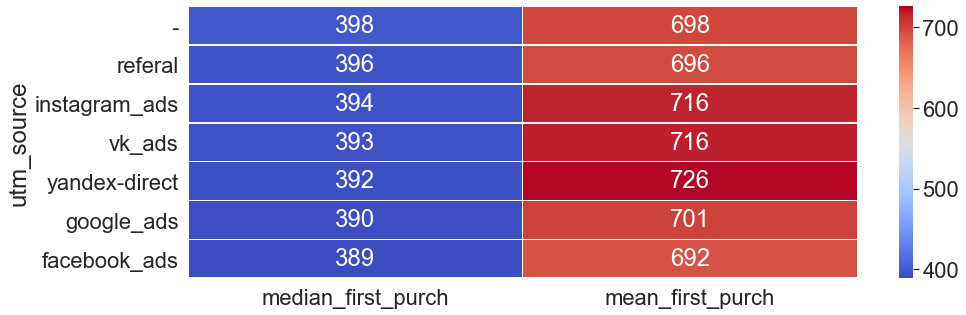

In [49]:
plt.figure(figsize = (15,5))
ax = sns.heatmap(median_mean, annot=True, fmt=".0f",  cmap="coolwarm", linewidths=.5)

### Выводы №7:
Средний первый чек отличается примерно в 2 раза от медианного по всем каналам привлечения.

Самый высокий медианный чек первой покупки у пользователей, пришедших со следующих каналов:
- Реферальная программа - 396
- Инстаграмм - 394


Самый низкий медианный чек первой покупки у пользователей, пришедших со следующих каналов:
- Фейсбук - 389
- Гугл - 390


Самый высокий средний чек первой покупки у пользователей, пришедших со следующих каналов:
- Яндекс - 726
- Инстаграмм, ВК - 716


Самый низкий средний чек первой покупки у пользователей, пришедших со следующих каналов:
- Фейсбук - 692
- Реферальная программа - 696

### 8. Анализ коэффициента возврата маркетинговых инвестиций (ROMI) по каналам привлечения

In [50]:
# Посчитаем доходы (income) по каналам привлечения
ROMI = data.query('event=="purchase"')\
            .groupby('utm_source', as_index = False)\
            .agg({'purchase_sum' : 'sum'})\
            .rename(columns = {'purchase_sum' : 'income'})
ROMI

,utm_source,income
0,-,21449749.5
1,facebook_ads,12249901.0
2,google_ads,12868276.0
3,instagram_ads,14546969.0
4,referal,8837044.5
5,vk_ads,16389652.5
6,yandex-direct,13915368.0


In [51]:
# Чтобы рассчитать затраты на реферальную программу, посчитаем количество пользователей, 
# привлеченных с помощью реферальной программы
count_users_referal = data.query('event=="purchase"')\
                            .drop_duplicates('device_id')['utm_source'].value_counts()
count_users_referal

-                14786
vk_ads           11460
yandex-direct    10936
google_ads       10167
instagram_ads     9820
facebook_ads      7903
referal           5803
Name: utm_source, dtype: int64

In [52]:
# Считаем расходы на реферальную программу
expenses_referal = 5803 * 200
expenses_referal

1160600

In [53]:
# Pассчитаем ROMI
ROMI['expenses'] = [0, 8590498, 10534878, 8561626, 1160600, 9553531, 10491707]
ROMI['ROMI'] = round((ROMI['income'] / ROMI['expenses'] - 1) * 100, 2)
ROMI = ROMI.sort_values('ROMI', ascending = False)
ROMI

,utm_source,income,expenses,ROMI
0,-,21449749.5,0,inf
4,referal,8837044.5,1160600,661.42
5,vk_ads,16389652.5,9553531,71.56
3,instagram_ads,14546969.0,8561626,69.91
1,facebook_ads,12249901.0,8590498,42.60
6,yandex-direct,13915368.0,10491707,32.63
2,google_ads,12868276.0,10534878,22.15


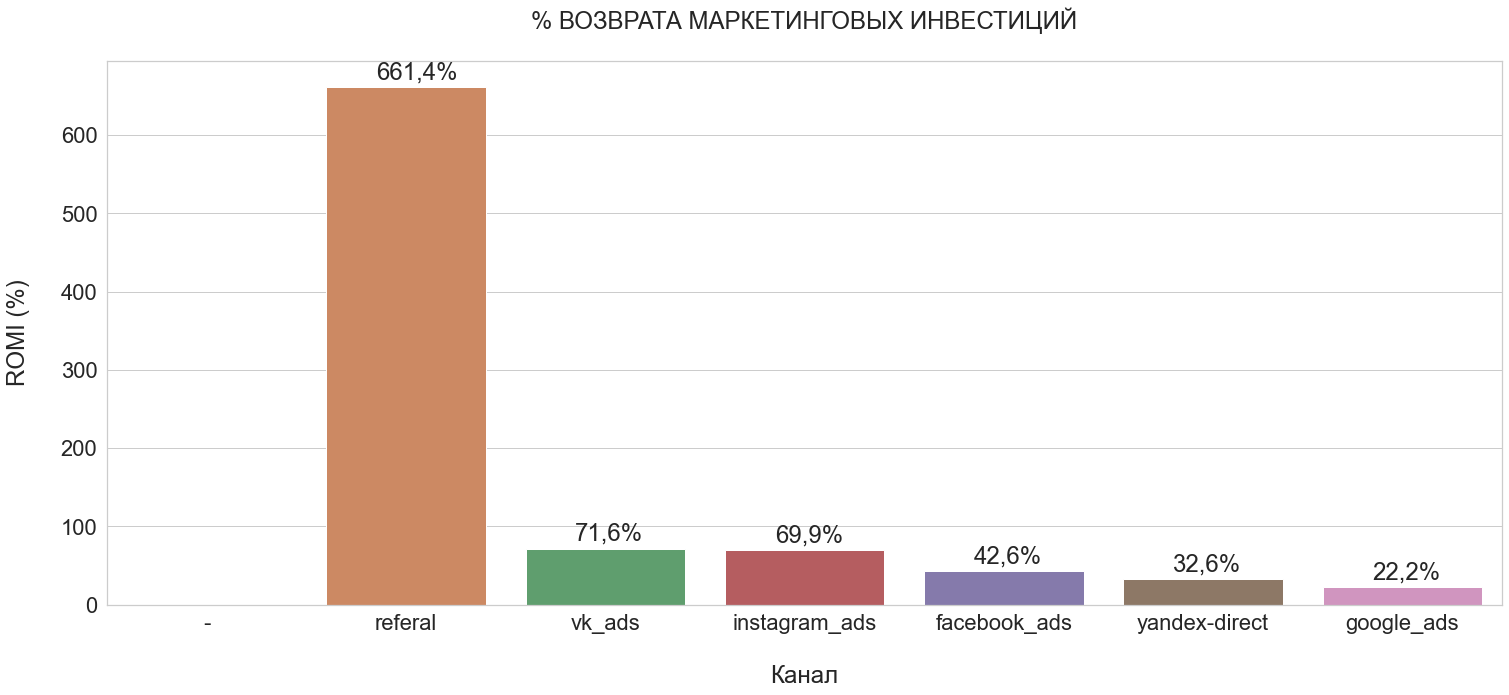

In [54]:
ax = sns.barplot(data = ROMI, x = 'utm_source', y = 'ROMI')
ax.set_title('% ВОЗВРАТА МАРКЕТИНГОВЫХ ИНВЕСТИЦИЙ\n')
ax.set_xlabel('\nКанал')
ax.set_ylabel('ROMI (%)\n')
plt.text(0.85, 671.4, '661,4%')
plt.text(1.85, 81.6, '71,6%')
plt.text(2.85, 79.9, '69,9%')
plt.text(3.85, 52.6, '42,6%')
plt.text(4.85, 42.6, '32,6%')
plt.text(5.85, 32.2, '22,2%')
plt.show()

### Выводы №8:
Самой выгодной оказалась Реферальная программа - ROMI=661.4%


Самым выгодным каналом привлечения является ВК - ROMI=71.6%, а самым не выгодным - Гугл -22.2%

### 9. Когортный анализ активности пользователей приложения (когорта - неделя первого посещения)

In [55]:
# Оставим только первое открытие приложения, чтобы выделить device_id для деления на когорты
first_start_app = data.query('event=="app_start"')\
                    .sort_values('date')\
                    .drop_duplicates('device_id')

In [56]:
# Создадим столбец с датой первого открытия приложения 
data['date_first_start'] = data['device_id'].map(first_start_app.set_index('device_id')['date'])
data.head()

,index,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,date_install,group_install,date_reg,reg_group,date_first_start
0,0,2020-01-01,app_start,0.0,android,669460,female,Moscow,-,2020-01-01,Установили в тот же день,2020-01-07,not_registered,2020-01-01
1,1,2020-01-01,app_start,0.0,ios,833621,male,Moscow,vk_ads,2020-01-01,Установили в тот же день,2020-01-01,not_registered,2020-01-01
2,2,2020-01-01,app_start,0.0,android,1579237,male,Saint-Petersburg,referal,NaT,Остальные,2020-01-01,not_registered,2020-01-01
3,3,2020-01-01,app_start,0.0,android,1737182,female,Moscow,facebook_ads,2020-01-01,Установили в тот же день,2020-01-01,not_registered,2020-01-01
4,5,2020-01-01,app_start,0.0,android,5148476,male,Saint-Petersburg,-,2020-01-01,Установили в тот же день,2020-01-24,not_registered,2020-01-01


In [57]:
# Извлекаем дату образования когорты
data['first_start_cohort'] = data['date_first_start'].apply(lambda x: x - dt.timedelta(days= x.weekday(), weeks=0))

# Добавляем неделю действия пользователя от даты образования когорты
data['week_num'] = data['date'] - data['first_start_cohort']
data['week_num'] = data['week_num'].apply(lambda x: x.days // 7 )

In [58]:
# Меняем тип данных в столбце 'first_start_cohort' и формируем таблицу для когортного анализа активности пользователей
data['first_start_cohort'] = data['first_start_cohort'].astype(str)
cohort_first_start = data.pivot_table(index = 'first_start_cohort',\
                     columns = 'week_num',\
                     values = 'device_id',\
                     aggfunc = pd.Series.nunique)
cohort_first_start

week_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13
first_start_cohort,,,,,,,,,,,,,,
2019-12-30,15705.0,7551.0,6792.0,6338.0,5794.0,5295.0,5452.0,5387.0,4853.0,4983.0,4541.0,4355.0,4498.0,2227.0
2020-01-06,31315.0,8228.0,6040.0,4958.0,4222.0,4540.0,4553.0,3507.0,4136.0,3246.0,2944.0,3047.0,1143.0,NaN
2020-01-13,30505.0,5068.0,3861.0,3122.0,3610.0,3175.0,2303.0,2894.0,1983.0,1818.0,1923.0,661.0,NaN,NaN
2020-01-20,12319.0,1863.0,1443.0,1706.0,1543.0,1079.0,1388.0,918.0,791.0,873.0,278.0,NaN,NaN,NaN
2020-01-27,13119.0,2037.0,1971.0,1669.0,1227.0,1397.0,1003.0,875.0,909.0,318.0,NaN,NaN,NaN,NaN
2020-02-03,10967.0,1993.0,1599.0,1126.0,1266.0,933.0,804.0,839.0,273.0,NaN,NaN,NaN,NaN,NaN
2020-02-10,16015.0,2560.0,1487.0,2083.0,1227.0,1019.0,1031.0,350.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17,11974.0,1511.0,1606.0,995.0,845.0,884.0,281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,5172.0,933.0,625.0,499.0,509.0,173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


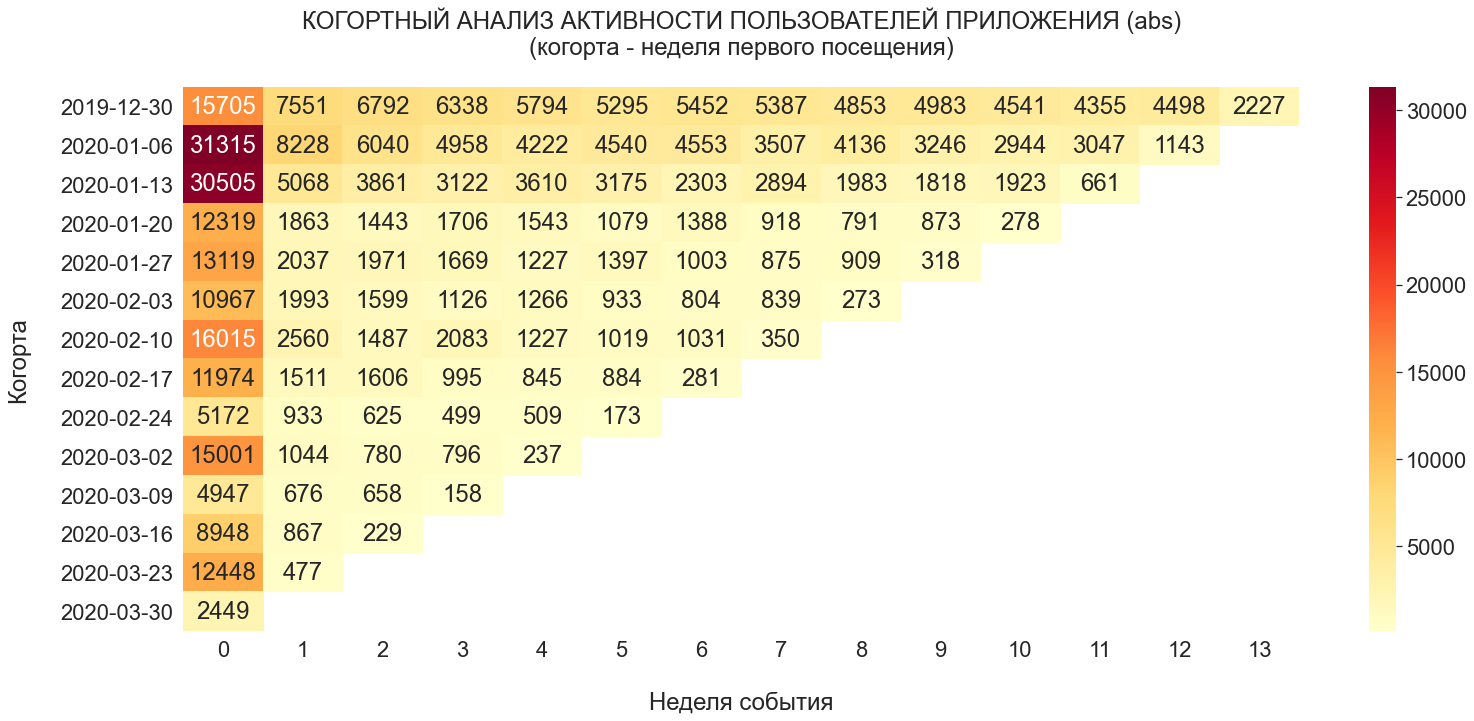

In [59]:
ax = sns.heatmap(cohort_first_start, annot=True, fmt=".0f",  cmap="YlOrRd")
ax.set_title("КОГОРТНЫЙ АНАЛИЗ АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ ПРИЛОЖЕНИЯ (abs)\n(когорта - неделя первого посещения)\n")
ax.set_xlabel('\n''Неделя события')
ax.set_ylabel('Когорта\n')
plt.show()   

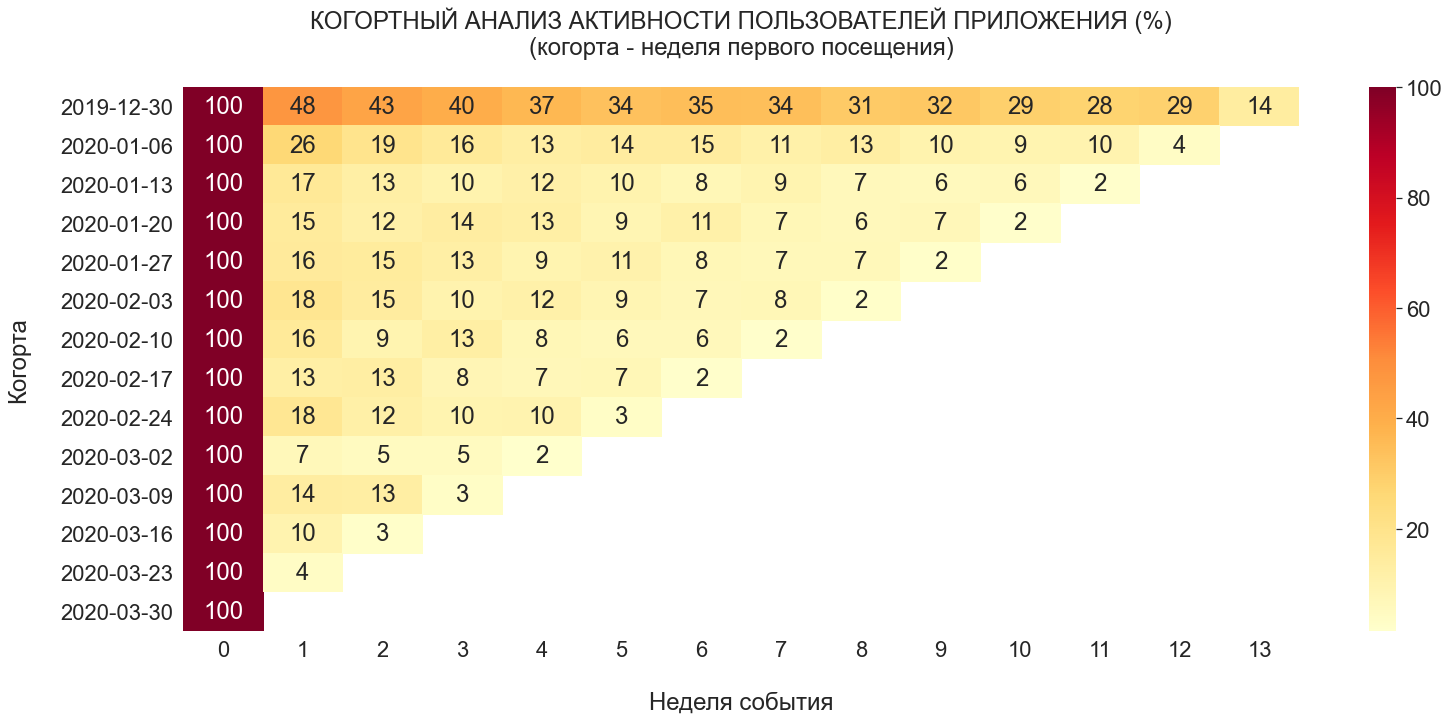

In [60]:
cohort_first_start = cohort_first_start.apply(lambda x: x*100/cohort_first_start[0])
ax = sns.heatmap(cohort_first_start, annot=True, fmt=".0f",  cmap = "YlOrRd")
ax.set_title("КОГОРТНЫЙ АНАЛИЗ АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ ПРИЛОЖЕНИЯ (%)\n(когорта - неделя первого посещения)\n")
ax.set_xlabel('\nНеделя события')
ax.set_ylabel('Когорта\n')
plt.show()

### Выводы №9:
- Самая активная когорта, как в абсолютных цифрах, так и в процентном соотношении — когорта, пришедшая на первой неделе (30.12.2012), ee активность в несколько раз выше, чем у остальных. 

- Когорты, пришедшие на 2 и 3 неделях (06.01.2020 и 13.01.2020) являются самыми многочисленными, однако в первую неделю их активность упала примерно в 4 и 6 раз.

 ### 10. Доля пользователей, регистрирующихся в день первого посещения (когорта - неделя первого посещения)

In [61]:
# Создадим функцию, которая будет сравнивать даты регистрации и первого входа
def group_start_reg(date_1, date_2, value_1, value_2):
    if date_1 == date_2:
        return value_1
    else:
        return value_2

In [62]:
# Создадим столбец с данными о регистрации в день первого открытия приложения
data['first_start_reg_group'] = data.apply(lambda x: group_start_reg(date_1 = x['date_first_start'], date_2 = x['date_reg'],
                                                                value_1 = 'Зарегистрировались в первый день',
                                                                value_2 = 'Не регистрировались в первый день'), axis = 1)

In [63]:
# Отфильтруем только первые открытия и посмотрим процент зарегистрировавшихся в этот день
percent_first_start_reg = data.query('event=="app_start"')\
                            .sort_values('date')\
                            .drop_duplicates('device_id')\
                            .groupby('first_start_reg_group', as_index = False)\
                            .agg({'device_id':'count'})\
                            .rename(columns = {'device_id' : 'count_users'})
percent_first_start_reg['total'] = percent_first_start_reg['count_users'].sum()
percent_first_start_reg['percent'] = percent_first_start_reg['count_users'] * 100 / percent_first_start_reg['total']
percent_first_start_reg

,first_start_reg_group,count_users,total,percent
0,Зарегистрировались в первый день,52402,190884,27.452275
1,Не регистрировались в первый день,138482,190884,72.547725


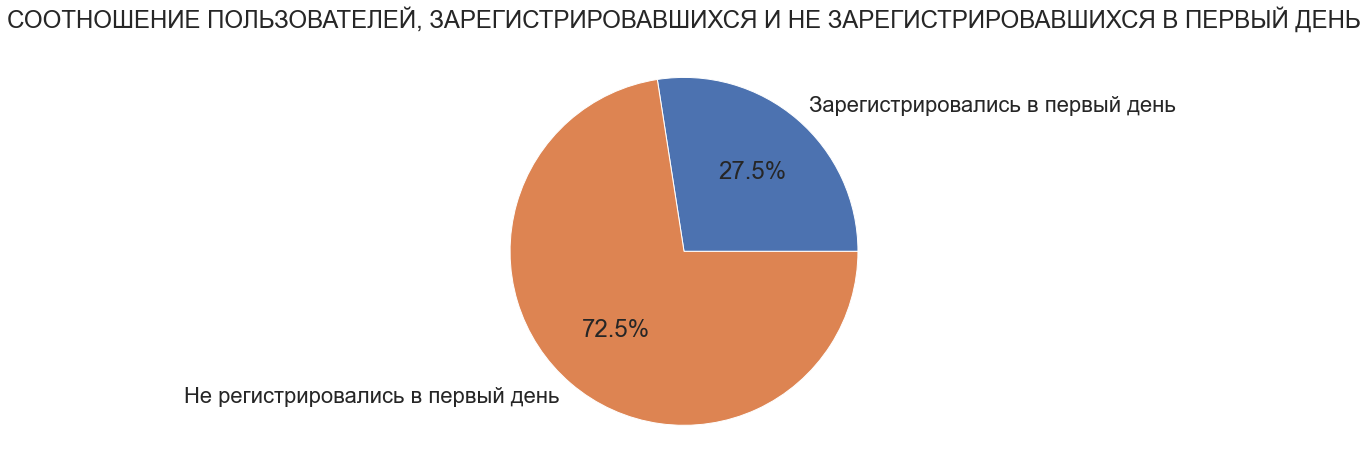

In [64]:
plt.figure(figsize=(8,8))
ax = plt.pie(labels = percent_first_start_reg['first_start_reg_group'], x = percent_first_start_reg['percent'],
             autopct='%1.1f%%')
plt.title('СООТНОШЕНИЕ ПОЛЬЗОВАТЕЛЕЙ, ЗАРЕГИСТРИРОВАВШИХСЯ И НЕ ЗАРЕГИСТРИРОВАВШИХСЯ В ПЕРВЫЙ ДЕНЬ')
plt.show()

### Выводы №10:
- Регистрируются в первый день всего 27.5% пользователей, основное количество пользователе совершают различные действия в течение некоторого времени, прежде чем принять решение о регистрации.


### 11. Когортный анализ LTV ( когорта - неделя первой покупки)

In [65]:
# Оставим только данные о первой покупке
first_purchase = data.query('event=="purchase"')\
                    .sort_values('date' )\
                    .drop_duplicates('device_id')\
                    .reset_index()

In [66]:
# Добавим в основной датафрейм столбец с датой первой покупки
data['date_first_purch'] = data['device_id'].map(first_purchase.set_index('device_id')['date'])

In [67]:
# Извлечем только данные с действием "покупка"
data_purch = data.query('event=="purchase"').reset_index()

# Получим дату образования когорты 
data_purch['first_purchase_cohort'] = data_purch['date_first_purch']\
                                         .apply(lambda x: x - dt.timedelta(days= x.weekday(), weeks=0))

# Добавляем неделю действия пользователя от даты образования когорты
data_purch['week_num_p'] = data_purch['date'] - data_purch['first_purchase_cohort'] 
data_purch['week_num_p'] = data_purch['week_num_p'].apply(lambda x: x.days // 7 ) 
data_purch['first_purchase_cohort'] = data_purch['first_purchase_cohort'].dt.strftime('%Y-%m-%d')
data_purch.head()           

,level_0,index,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,...,group_install,date_reg,reg_group,date_first_start,first_start_cohort,week_num,first_start_reg_group,date_first_purch,first_purchase_cohort,week_num_p
0,5296,7691,2020-01-01,purchase,265.5,android,6081155,female,Moscow,-,...,Установили в тот же день,2020-01-01,not_registered,2020-01-01,2019-12-30,0,Зарегистрировались в первый день,2020-01-01,2019-12-30,0
1,5297,7692,2020-01-01,purchase,374.0,android,77448,female,Saint-Petersburg,yandex-direct,...,Установили в тот же день,2020-01-01,not_registered,2020-01-01,2019-12-30,0,Зарегистрировались в первый день,2020-01-01,2019-12-30,0
2,5298,7693,2020-01-01,purchase,98.5,ios,7458607,female,Moscow,instagram_ads,...,Установили в тот же день,2020-01-01,not_registered,2020-01-01,2019-12-30,0,Зарегистрировались в первый день,2020-01-01,2019-12-30,0
3,5299,7694,2020-01-01,purchase,304.5,ios,3520947,male,Moscow,instagram_ads,...,Установили в тот же день,2020-01-01,not_registered,2020-01-01,2019-12-30,0,Зарегистрировались в первый день,2020-01-01,2019-12-30,0
4,5300,7695,2020-01-01,purchase,153.5,android,1170605,male,Moscow,google_ads,...,Установили в тот же день,2020-01-01,not_registered,2020-01-01,2019-12-30,0,Зарегистрировались в первый день,2020-01-01,2019-12-30,0


In [68]:
# Посчитаем какая когорта принесла больше всего денег? 
first_purchase_cohort_LTV = data_purch.groupby('first_purchase_cohort')\
                                .agg({'purchase_sum' : 'sum'})\
                                .rename(columns = {'purchase_sum' : 'LTV'})\
                                .sort_values('first_purchase_cohort')\
                                .reset_index()
first_purchase_cohort_LTV

,first_purchase_cohort,LTV
0,2019-12-30,12320177.5
1,2020-01-06,19787838.0
2,2020-01-13,18852452.0
3,2020-01-20,9018049.5
4,2020-01-27,7432634.0
5,2020-02-03,6305237.0
6,2020-02-10,6766314.0
7,2020-02-17,5398837.5
8,2020-02-24,3067633.5
9,2020-03-02,3629773.0


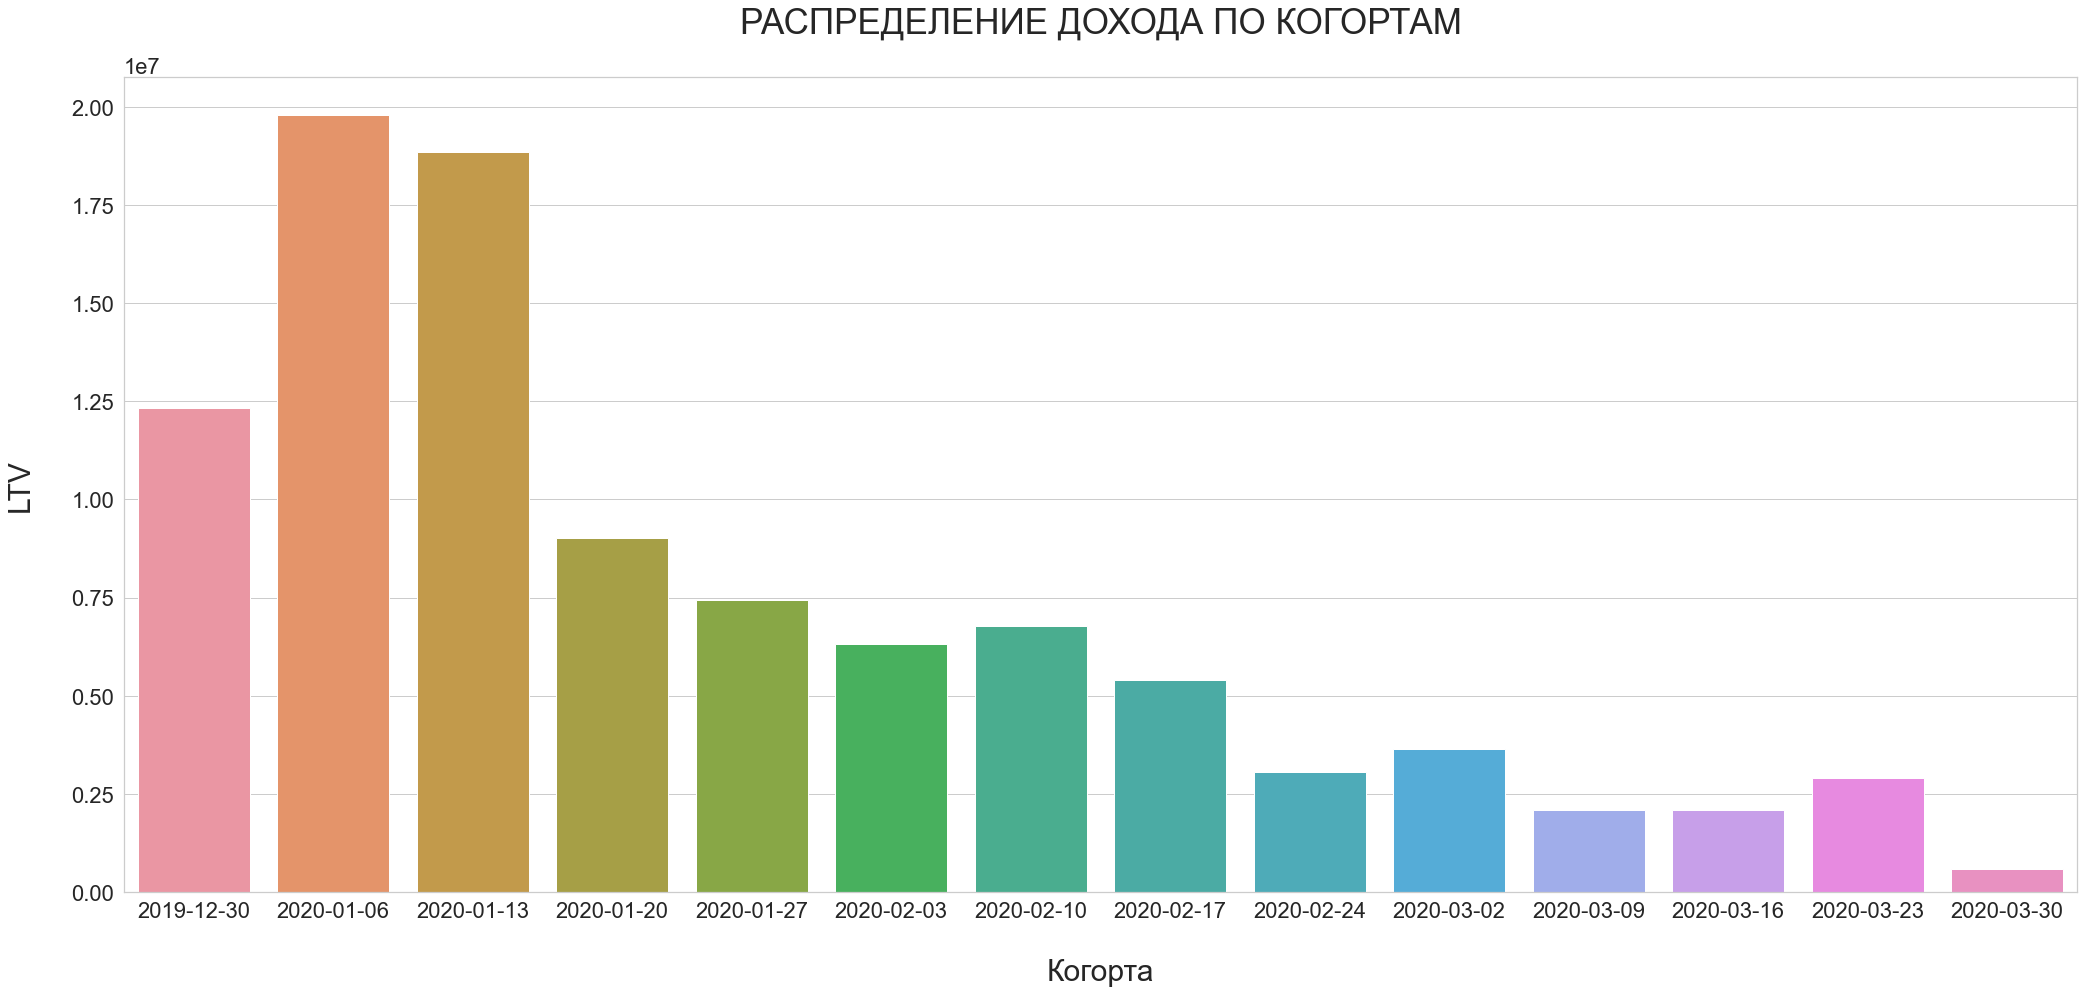

In [69]:
plt.figure(figsize=(35,15))
ax = sns.barplot(data = first_purchase_cohort_LTV, x = 'first_purchase_cohort', y = 'LTV')
ax.set_title('РАСПРЕДЕЛЕНИЕ ДОХОДА ПО КОГОРТАМ\n', fontsize = 35)
ax.set_xlabel('\nКогорта', fontsize = 30)
ax.set_ylabel('LTV\n', fontsize = 30)
plt.show()

### Выводы №11:
- Самый большой доход приходится на когорты, пользователи которых, совершили первую покупку на 2-ой (06.01.2020) и 3-ей (13.01.2020) неделях.
    - когорта 06.01.2020 - LTV = 19 787 838
    - когорта 13.01.2020 - LTV = 18 852 452

### 12. Когортный анализ медианного и среднего чека первой покупку ( когорта - неделя первой покупки)

In [70]:
# Рассчитаем медианный чек по когортам (когорта - неделя первой покупки)
first_purchase_cohort_median = data_purch.pivot_table(index = 'first_purchase_cohort',
                                                      columns = 'week_num_p',
                                                      values = 'purchase_sum',
                                                      aggfunc = pd.Series.median)
first_purchase_cohort_median

week_num_p,0,1,2,3,4,5,6,7,8,9,10,11,12,13
first_purchase_cohort,,,,,,,,,,,,,,
2019-12-30,395.00,390.50,391.50,369.50,392.00,394.75,382.00,375.50,399.50,385.0,402.50,405.5,400.50,380.75
2020-01-06,396.00,396.00,393.50,388.25,402.50,411.00,371.00,420.25,385.50,385.5,377.50,410.0,411.25,NaN
2020-01-13,389.50,392.00,390.00,398.50,391.00,385.25,396.50,400.75,400.50,397.0,411.00,423.5,NaN,NaN
2020-01-20,397.50,404.00,366.50,377.00,384.50,395.50,397.50,406.25,388.00,375.0,452.75,NaN,NaN,NaN
2020-01-27,394.75,389.00,386.50,397.00,389.75,385.50,393.50,392.00,401.00,353.0,NaN,NaN,NaN,NaN
2020-02-03,398.00,410.25,404.25,381.25,419.00,409.00,387.00,357.00,327.25,NaN,NaN,NaN,NaN,NaN
2020-02-10,397.00,380.25,396.50,403.00,431.25,421.00,382.00,364.50,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17,392.00,392.00,388.25,391.50,421.50,407.00,418.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,383.00,415.50,415.50,375.50,409.50,381.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


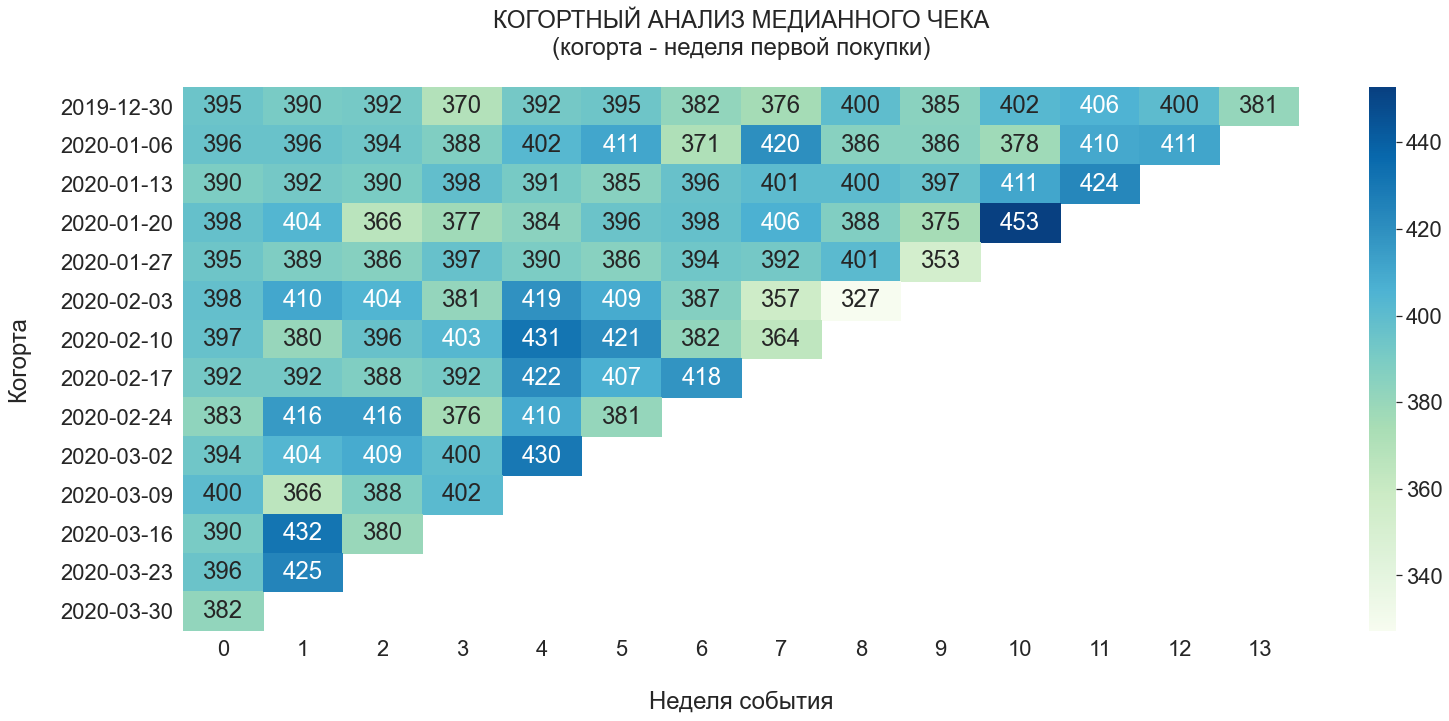

In [71]:
ax = sns.heatmap(first_purchase_cohort_median, annot=True, fmt=".0f",  cmap="GnBu")
ax.set_title("КОГОРТНЫЙ АНАЛИЗ МЕДИАННОГО ЧЕКА\n(когорта - неделя первой покупки)\n")
ax.set_xlabel('\nНеделя события')
ax.set_ylabel('Когорта\n')
plt.show()

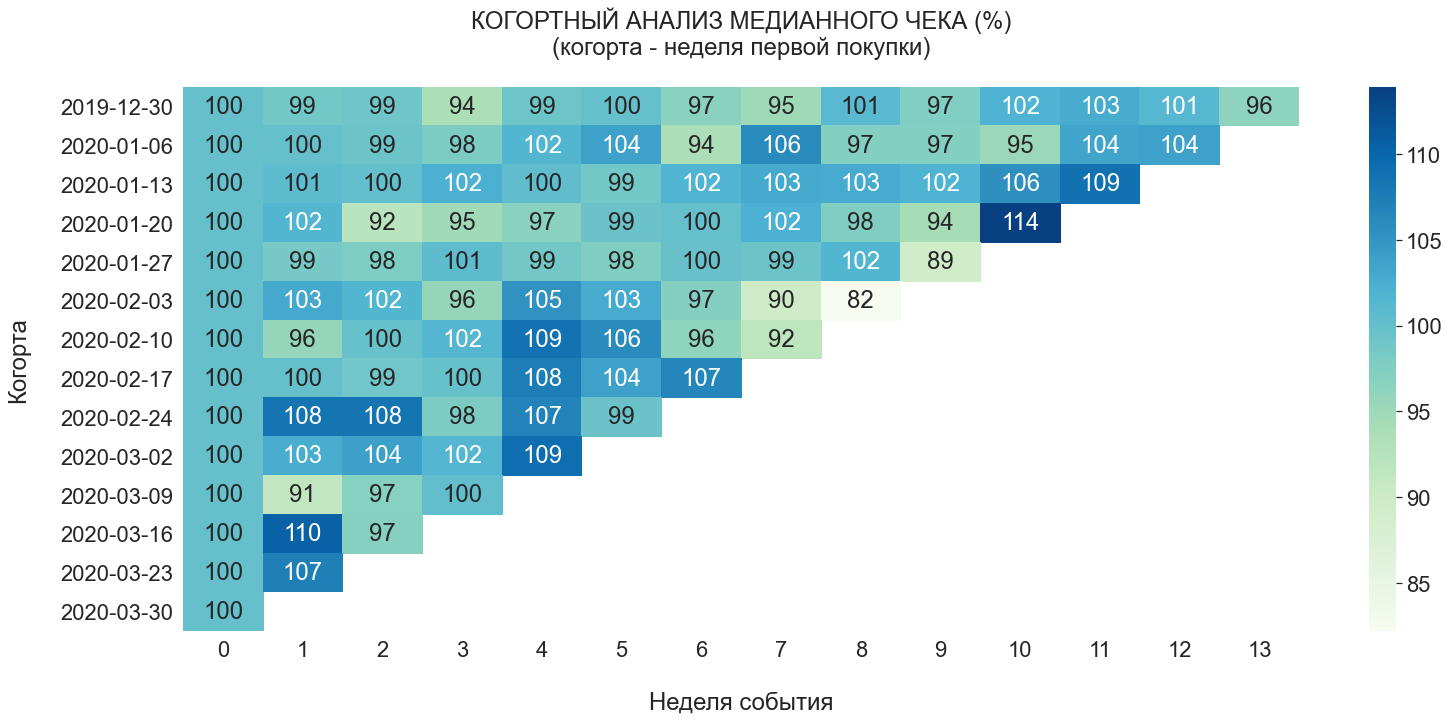

In [72]:
first_purchase_cohort_median = first_purchase_cohort_median.apply(lambda x: x*100/first_purchase_cohort_median[0])
ax = sns.heatmap(first_purchase_cohort_median, annot=True, fmt=".0f",  cmap = "GnBu")
ax.set_title("КОГОРТНЫЙ АНАЛИЗ МЕДИАННОГО ЧЕКА (%)\n(когорта - неделя первой покупки)\n")
ax.set_xlabel('\n''Неделя события')
ax.set_ylabel('Когорта\n')
plt.show()   

In [73]:
# Рассчитаем средний чек по когортам (когорта - неделя первой покупки)
first_purchase_cohort_mean = data_purch.pivot_table(index = 'first_purchase_cohort',
                                                      columns = 'week_num_p',
                                                      values = 'purchase_sum',
                                                      aggfunc = pd.Series.mean)
first_purchase_cohort_mean

week_num_p,0,1,2,3,4,5,6,7,8,9,10,11,12,13
first_purchase_cohort,,,,,,,,,,,,,,
2019-12-30,705.843019,702.058445,689.420778,728.139324,701.942944,756.619612,682.567582,705.765851,707.142080,706.003632,641.120261,746.500000,709.281984,723.813889
2020-01-06,709.904051,655.862088,746.271406,771.551617,718.495031,723.622214,713.889272,750.932895,636.608734,718.421187,688.632026,708.356826,666.470930,NaN
2020-01-13,691.691770,740.777144,743.668719,738.696844,666.309194,635.409894,785.809904,697.582386,777.172634,653.134707,666.981651,848.610345,NaN,NaN
2020-01-20,731.400224,732.434314,655.906918,656.352820,693.083445,778.638564,666.306050,712.882172,813.666667,668.990323,703.486486,NaN,NaN,NaN
2020-01-27,692.044825,694.626705,625.775714,685.777860,711.178571,661.537578,664.075980,670.028455,660.684915,971.068493,NaN,NaN,NaN,NaN
2020-02-03,737.060314,692.054430,806.613057,807.580169,643.468889,827.884932,644.062500,602.646974,524.192308,NaN,NaN,NaN,NaN,NaN
2020-02-10,708.890188,659.956263,721.002373,651.677390,671.466749,683.458209,790.246356,847.007463,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17,690.066371,731.704324,755.279863,733.104265,785.193811,697.231707,815.422414,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,739.135983,811.235644,729.686567,630.971074,676.906574,725.836538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


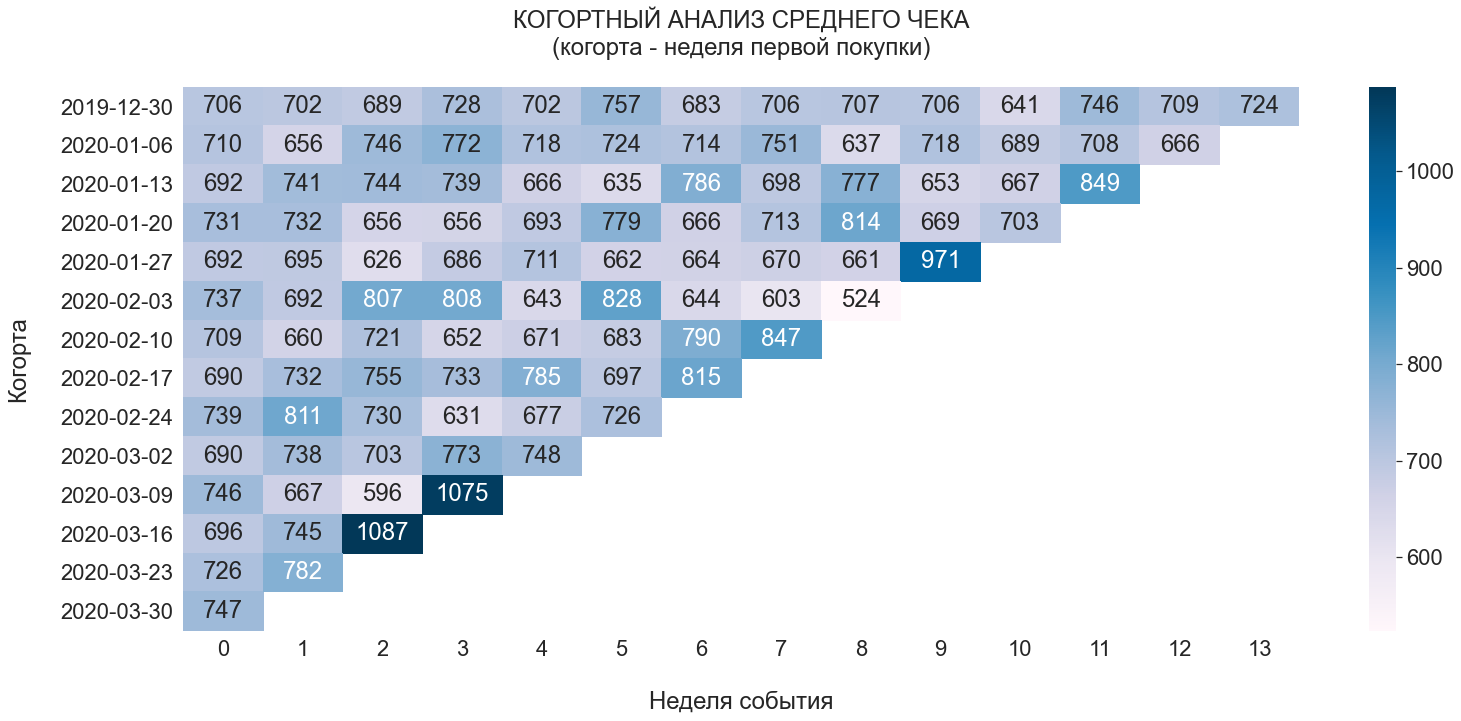

In [74]:
ax = sns.heatmap(first_purchase_cohort_mean, annot=True, fmt=".0f",  cmap="PuBu")
ax.set_title("КОГОРТНЫЙ АНАЛИЗ СРЕДНЕГО ЧЕКА\n(когорта - неделя первой покупки)\n")
ax.set_xlabel('\nНеделя события')
ax.set_ylabel('Когорта\n')
plt.show()

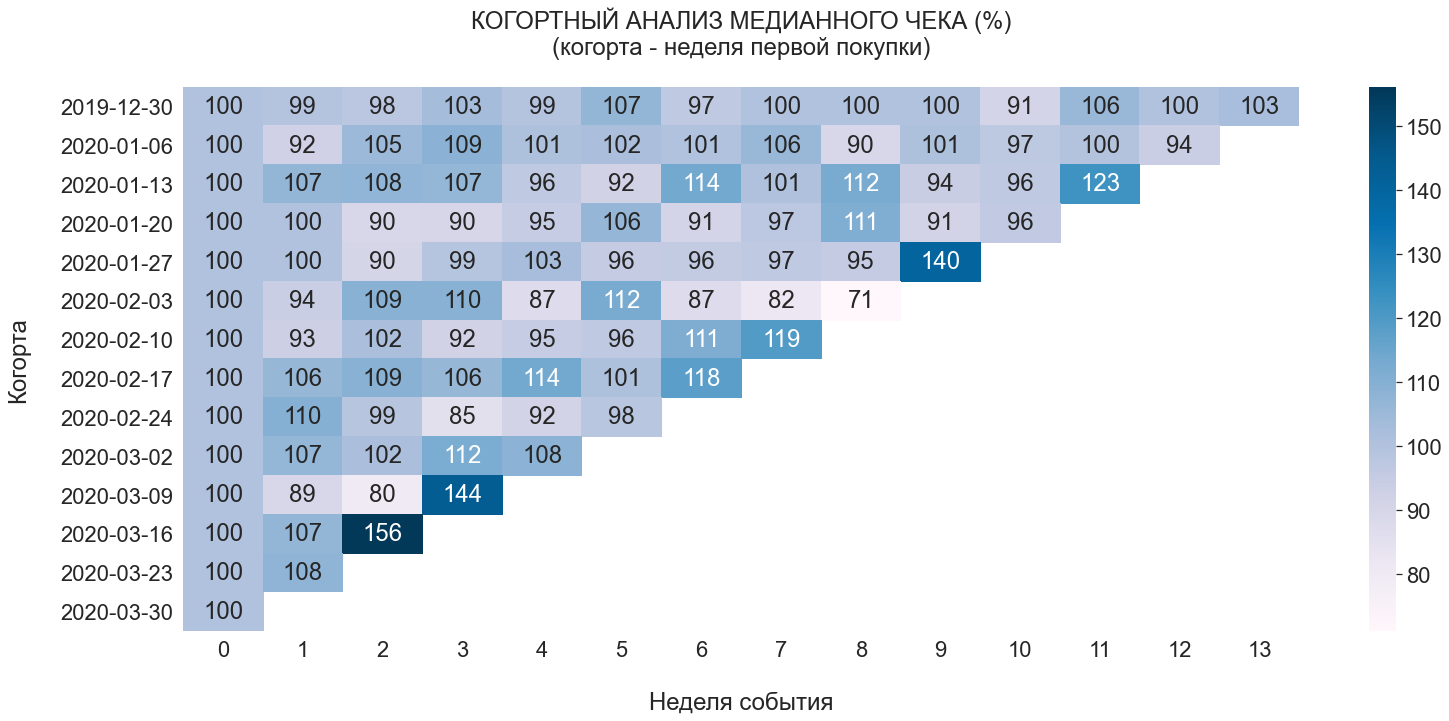

In [75]:
first_purchase_cohort_mean = first_purchase_cohort_mean.apply(lambda x: x*100/first_purchase_cohort_mean[0])
ax = sns.heatmap(first_purchase_cohort_mean, annot=True, fmt=".0f",  cmap = "PuBu")
ax.set_title("КОГОРТНЫЙ АНАЛИЗ МЕДИАННОГО ЧЕКА (%)\n(когорта - неделя первой покупки)\n")
ax.set_xlabel('\n''Неделя события')
ax.set_ylabel('Когорта\n')
plt.show()   

### Выводы №12:
- Самый большой медианный чек на неделе первой покупки у когорты "09.03.2020" - 400, а самый низкий у когорты 30.03.2020 - 382.

- Самый большой средний чек на неделе первой покупки у когорты "30.03.2020" - 747, а самый низкий у когорт "02.03.2020" и "17.02.2020" - 690.

- У многих когорт средний и медианный чек со временем растут по сравнению с первой неделей.

### 13. Анализ медианного и среднего чеков в разный период времени с момента первой покупки по каналам привлечения

In [76]:
# Посчитаем медианный чек
median_check_source = data_purch.pivot_table(index = 'utm_source',
                                 columns = 'week_num_p',
                                 values = 'purchase_sum',
                                 aggfunc = 'median')
median_check_source

week_num_p,0,1,2,3,4,5,6,7,8,9,10,11,12,13
utm_source,,,,,,,,,,,,,,
-,398.00,400.50,397.50,398.0,389.00,390.0,396.5,393.25,402.5,380.5,399.50,415.50,408.00,401.50
facebook_ads,388.50,396.00,406.00,407.0,394.25,392.5,380.0,418.00,402.5,400.0,402.25,432.50,413.75,370.50
google_ads,391.50,385.00,379.00,375.0,409.50,399.5,388.5,377.00,377.0,399.0,403.00,404.50,416.50,300.00
instagram_ads,396.00,414.00,389.50,397.0,409.50,397.5,392.0,392.50,377.5,399.0,402.00,395.25,409.25,356.25
referal,393.75,376.25,386.50,374.5,399.00,395.5,362.0,370.00,365.0,365.0,403.00,379.00,401.00,390.25
vk_ads,393.00,398.00,382.50,382.0,410.00,405.0,382.0,407.25,390.5,385.0,376.00,421.75,379.00,362.50
yandex-direct,392.50,390.50,384.25,388.0,395.75,415.0,409.0,395.00,395.0,405.5,397.50,413.00,371.75,384.50


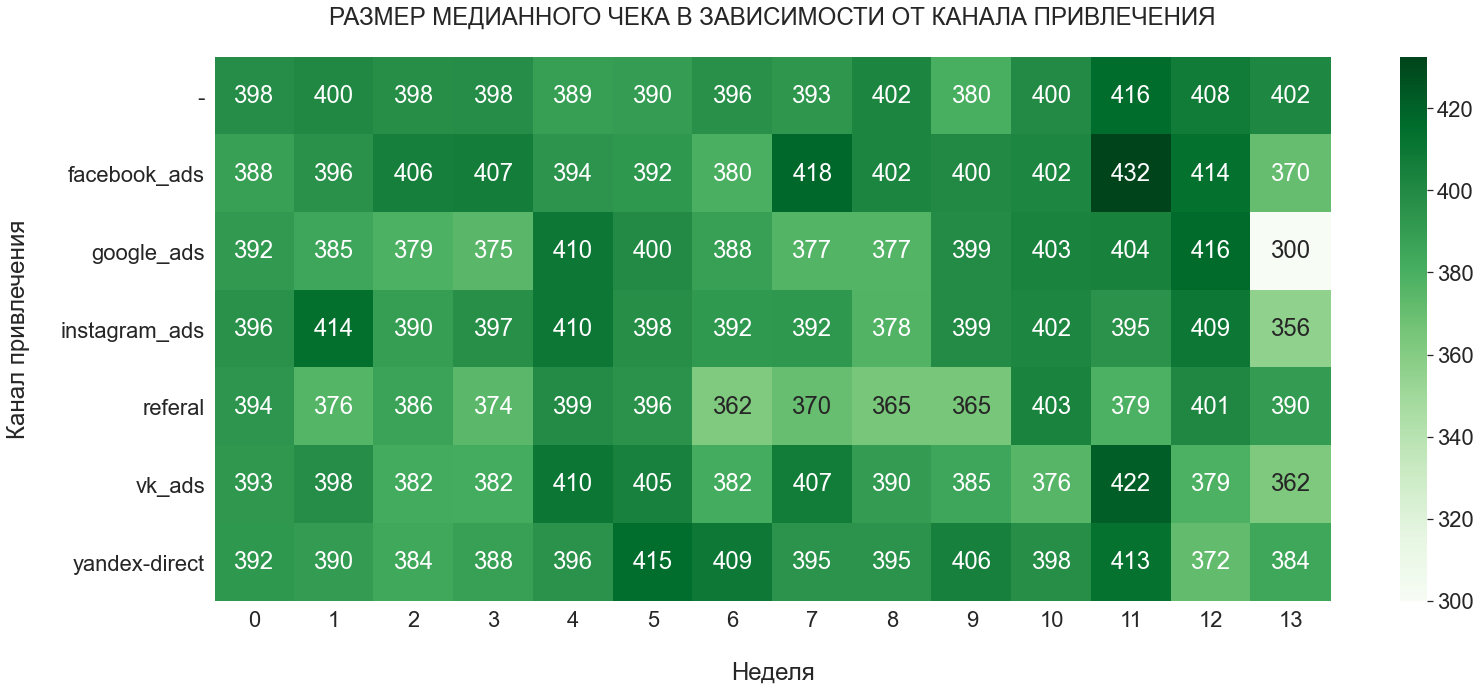

In [77]:
ax = sns.heatmap(median_check_source, annot=True, fmt=".0f", cmap= 'Greens')
ax.set_title('РАЗМЕР МЕДИАННОГО ЧЕКА В ЗАВИСИМОСТИ ОТ КАНАЛА ПРИВЛЕЧЕНИЯ\n')
ax.set_xlabel('\n''Неделя')
ax.set_ylabel('Канал привлечения\n')
plt.show()

In [78]:
# Посчитаем средний чек
mean_check_source = data_purch.pivot_table(index = 'utm_source',
                                 columns = 'week_num_p',
                                 values = 'purchase_sum',
                                 aggfunc = 'mean')
mean_check_source

week_num_p,0,1,2,3,4,5,6,7,8,9,10,11,12,13
utm_source,,,,,,,,,,,,,,
-,698.686082,727.371081,704.780839,780.361478,669.369788,700.696356,778.044244,708.302061,727.587515,655.670571,599.141199,667.961905,817.976959,783.674419
facebook_ads,691.588879,710.536461,818.986960,768.068182,705.310520,747.350444,647.595624,659.144834,734.254184,725.028455,689.212733,833.605911,751.284483,700.383333
google_ads,707.327936,675.674856,650.002334,650.650630,684.617497,704.376766,736.246903,699.355599,719.808434,658.719373,619.835878,736.393782,654.450549,669.100000
instagram_ads,720.796417,732.656620,804.986891,724.494086,725.772298,652.620146,735.590849,665.959459,678.837702,717.168632,655.780627,647.954198,807.451389,367.863636
referal,687.762156,650.062500,691.552745,707.435198,684.971200,714.275832,698.279070,768.792162,602.934286,729.451456,774.819923,692.343023,480.289720,631.527778
vk_ads,718.637622,718.140325,657.973975,766.475272,672.478221,784.700424,641.633995,752.249247,669.782537,652.677189,718.956919,810.293796,626.622699,899.606061
yandex-direct,726.491734,685.402318,693.931050,643.646542,743.505625,688.378648,735.940925,709.916501,761.077381,819.244928,650.843173,821.365854,639.345000,862.789474


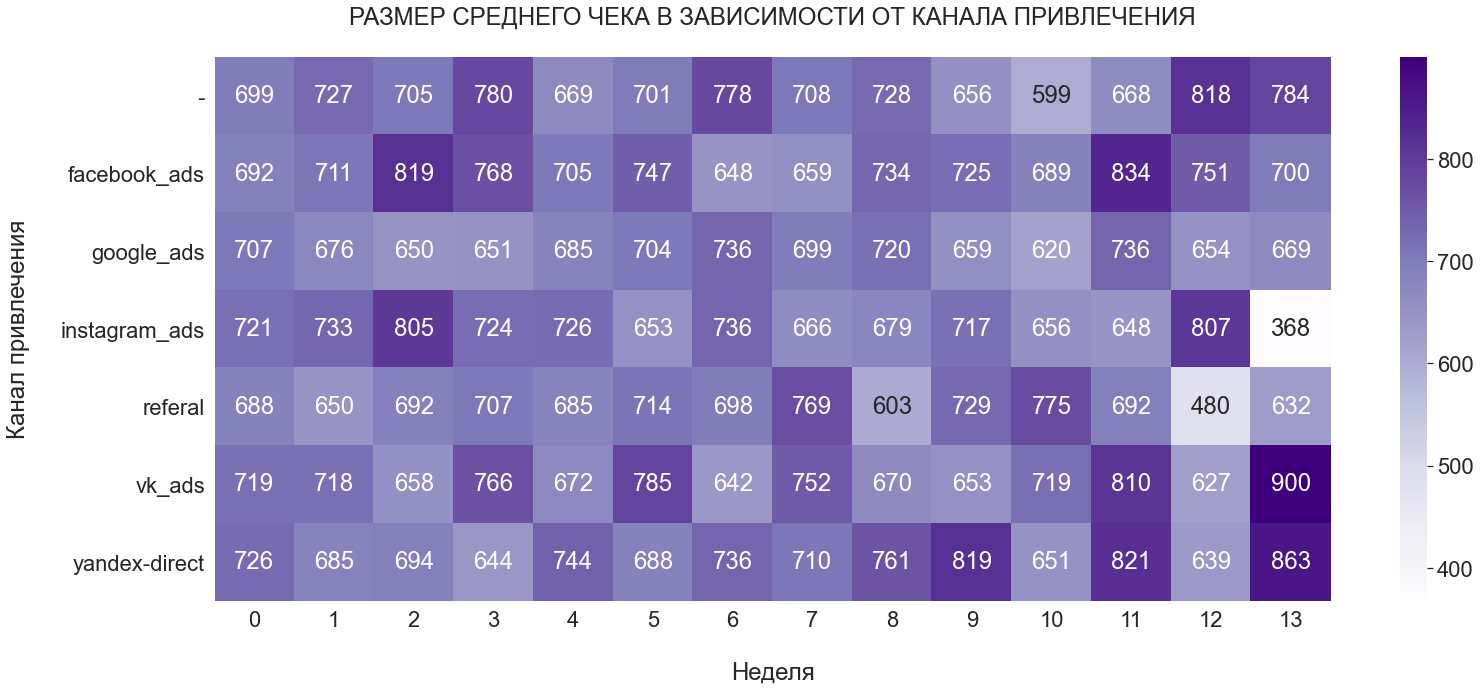

In [79]:
ax = sns.heatmap(mean_check_source, annot=True, fmt=".0f", cmap= 'Purples')
ax.set_title('РАЗМЕР СРЕДНЕГО ЧЕКА В ЗАВИСИМОСТИ ОТ КАНАЛА ПРИВЛЕЧЕНИЯ\n')
ax.set_xlabel('\n''Неделя')
ax.set_ylabel('Канал привлечения\n')
plt.show()

### Выводы №13:

- Самый большой медианный чек на неделе первой покупки у пользователей, пришедших из Инстаграмм - 396, а самый низкий у пользователей, пришедших из Фейсбука - 388. 

- Самый большой средний чек на неделе первой покупки у пользователей, пришедших из Яндекса - 726, а самый низкий у пользователей, воспользовавшихся Реферальной программой - 688

- Стоит заметить, что с течением времени сердний и медианный чеки у многих каналов привлечения растут. Например, у пользователей, пришедших с Фейсбука на первой неделе средний чек был самым маленьким (388) по сравнению с другими каналами привлечения, а на 11 неделе - самым большим (432).

### ВЫВОДЫ ПО ВСЕМУ ПРОЕКТУ:
##### ЭФФЕКТИВНОСТЬ КАНАЛОВ ПРИВЛЕЧЕНИЯ И ВОРОНКА ПРОДАЖ:
##### Анализ динамики всех событий по дням:
- Количество событий распределены по дням не равномерно: 
    - наблюдается резкий подъем активности 10 января, 14,21 февраля и 6,7 марта 2020 года; 
    - выше среднего показатели 11, 13, 14 января и 24, 25 марта;
    - спад активности произошел в новогодние праздники, 3-4, 15-17 марта и в конце марта-начале апреля;
    - самая высокая активность была 10 января, а самая низкая 7 января 2020.

- Необходимо  подумать, как увеличить привлечение пользователей в выходные и праздничные дни и выяснить причину спада активности.

##### Анализ распределения трафика и динамики открытий приложения группами пользователей, установивших приложение в день первого открытия, и остальными пользователями.
- 79,35% от всех открытий приложения приходится на пользователей, НЕ устанавливавших приложение в первый день;

- Динамика открытий приложения по дням в двух группах идентичная, за исключением новогодних праздников (т.е. всплески активности и падения ее происходят в одни и те же периоды, за исключением новогодних праздников). 

- Максимальные значения активности в группе "Установили в тот же день" наблюдаются 1-2 и 10-16 января, 6-7 марта и 14 февраля, а минимальные - 2-5 и 14-17 марта, 25-28 февраля.

- Максимальные значения активности в группе "Остальные" наблюдаются 10-11 января, 6-7 и 24-26 марта,  14-16 и 21-22 февраля, а минимальные - 1-9 января и 28-31 марта.

##### Анализ трафика от инсталлов
- Основная доля трафика приходится на открытие приложения, что очевидно, т.к. установка требуется всего один раз, в отличии от открытия приложения;
- Максимальная доля трафика от инсталлов приходится на 1, 2 и 10 января (80.52%, 61.63% и 61.16%), а в абсолютном выражении максимальное количество инсталов 10 января - 13206 установок, а 1 января всего 3579.
- Минимальная доля трафика от инсталлов приходится на 16 и 17 марта - 5.86% и 6.59% и в абсолютном выражении минимальное количество установок приходится на 16 марта - 360.

##### Анализ количества установок и первых открытий приложения по каналам привлечения
- Самыми эффективными каналами по привлечению пользователей являются Яндекс, Гугл и ВК:
    - Янедкс - 18% новых пользователей
    - Гугл - 16.5%
    - ВК - 14.6%
    
- Самыми эффективными каналами по установкам приложения тоже являются Яндекс, Гугл и ВК:
    - Янедкс - 19% 
    - Гугл - 17%
    - ВК - 15%
    
- Меньше всего пользователей и установок от Реферальной программы и Фейсбука.

- Динамика первых открытий и установок приложения по дням идентичная по всем каналам (т.е. всплески и падения происходят в одни и те же периоды). 

##### Анализ воронки для зарегистрированных и незарегистрированных пользователей по каналам привлечения
- В группе зарегистрированных пользователей большая часть клиентов "отваливается" на этапе покупки (конверсия в покупку составляет 69-76%). Однако, стоит заметить, что показатели конверсии в покупку достатьчно высоки. Лидерами конверсии на этом этапе являются:
    - Реферальная программа - 76%
    - ВК - 76%
    - Инстаграмм - 73%

- В группе незарегистрированных пользователей большая часть клиентов "отваливается" на этапе регистрации (конверсия в регистрацию составляет 55-65%). Возможно, стоит задуматься об упрощении процедуры регистрации. Лидерами конверсии на этом этапе являются:
    - Реферальная программа - 65%
    - ВК - 62%
    - Инстаграмм - 60%
    
- У незарегистрированных пользователей процент конверсии в покупку выше, чем у зарегистрированных, однако на всех остальных этапах конверсия выше у зарегистрированных пользователей.

##### Анализ конверсии в первую покупку по каналам привлечения
- Самыми эффективными каналами привлечения по конверсии в покупку являются:
    - Реферальная программа - 48.4%
    - Фейсбук - 41.9%
    - ВК - 41.1%

- Самыми неэффективными каналами привлечения по конверсии в покупку являются:
    - Яндекс - 31.8%
    - Гугл - 32.3%

##### Анализ среднего и медианного первого чека по каналам привлечения
- Средний первый чек отличается примерно в 2 раза от медианного по всем каналам привлечения.

- Самый высокий медианный чек первой покупки у пользователей, пришедших со следующих каналов:
    - Реферальная программа - 396
    - Инстаграмм - 394


- Самый низкий медианный чек первой покупки у пользователей, пришедших со следующих каналов:
    - Фейсбук - 389
    - Гугл - 390

- Самый высокий средний чек первой покупки у пользователей, пришедших со следующих каналов:
    - Яндекс - 726
    - Инстаграмм, ВК - 716

- Самый низкий средний чек первой покупки у пользователей, пришедших со следующих каналов:
    - Фейсбук - 692
    - Реферальная программа - 696

##### Анализ ROMI по каналам привлечения
- Самой выгодной оказалась Реферальная программа - ROMI=661.4%
- Самым выгодным каналом привлечения является ВК - ROMI=71.6%, а самым не выгодным - Гугл -22.2%



##### ПОЛЬЗОВАТЕЛЬСКАЯ АНАЛИТИКА:

##### Когортный анализ активности пользователей приложения (когорта - неделя первого посещения)
- Самая активная когорта, как в абсолютных цифрах, так и в процентном соотношении — когорта, пришедшая на первой неделе (30.12.2012), ee активность в несколько раз выше, чем у остальных. 

- Когорты, пришедшие на 2 и 3 неделях (06.01.2020 и 13.01.2020) являются самыми многочисленными, однако в первую неделю их активность упала примерно в 4 и 6 раз.

##### Доля пользователей, регистрирующихся в день первого посещения (когорта - неделя первого посещения)
- Регистрируются в первый день всего 27.5% пользователей, основное количество пользователе совершают различные действия в течение некоторого времени, прежде чем принять решение о регистрации.

##### Когортный анализ LTV (когорта - неделя первой покупки)
- Самый большой доход приходится на когорты, пользователи которых, совершили первую покупку на 2-ой (06.01.2020) и 3-ей (13.01.2020) неделях.
    - когорта 06.01.2020 - LTV = 19 787 838
    - когорта 13.01.2020 - LTV = 18 852 452

##### Когортный анализ медианного и среднего чека первой покупку ( когорта - неделя первой покупки)
- Самый большой медианный чек на неделе первой покупки у когорты "09.03.2020" - 400, а самый низкий у когорты 30.03.2020 - 382.

- Самый большой средний чек на неделе первой покупки у когорты "30.03.2020" - 747, а самый низкий у когорт "02.03.2020" и "17.02.2020" - 690.

- У многих когорт средний и медианный чек со временем растут по сравнению с первой неделей.

##### Анализ медианного и среднего чеков в разный период времени с момента первой покупки по каналам привлечения
- Самый большой медианный чек на неделе первой покупки у пользователей, пришедших из Инстаграмм - 396, а самый низкий у пользователей, пришедших из Фейсбука - 388. 

- Самый большой средний чек на неделе первой покупки у пользователей, пришедших из Яндекса - 726, а самый низкий у пользователей, воспользовавшихся Реферальной программой - 688

- Стоит заметить, что с течением времени сердний и медианный чеки у многих каналов привлечения растут. Например, у пользователей, пришедших с Фейсбука на первой неделе средний чек был самым маленьким (388) по сравнению с другими каналами привлечения, а на 11 неделе - самым большим (432).
